### Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset containing information of KOLKATA cars

In [2]:
df=pd.read_csv('cleaned_kolkata_cars.csv')
df.head()

,Unnamed: 0,id,car_from,it,ft,bt,km,transmission,ownerNo,owner,...,Turbo Charger,Turning Radius,Tyre Type,Value Configuration,Values per Cylinder,Wheel Base,Wheel Size,Width,d,id.3
0,0,0,kolkata,0,Petrol,Sedan,"70,000",Automatic,3,3rd Owner,...,No,5.5 metres,"Tubeless,Radial",DOHC,4.0,2775mm,17,1825mm,NaN,0
1,1,1,kolkata,0,Petrol,Hatchback,"23,981",Manual,1,1st Owner,...,No,4.7m,NaN,DOHC,4.0,2348mm,NaN,1560mm,NaN,1
2,2,2,kolkata,0,Petrol,SUV,"7,100",Automatic,1,1st Owner,...,NaN,NaN,"Tubeless, Radial",NaN,4.0,2500,NaN,1750,NaN,2
3,3,3,kolkata,0,Petrol,Hatchback,"71,574",Manual,2,2nd Owner,...,No,5.20 m,"Tubeless,Radial",DOHC,4.0,"2,525 mm",14,1710 mm,NaN,3
4,4,4,kolkata,0,Diesel,SUV,"50,000",Automatic,2,2nd Owner,...,Yes,5.9 metres,"Tubeless,Radial",DOHC,4.0,2603mm,16,2019mm,NaN,4


In [3]:
df.shape

(1381, 247)

In [4]:
len(df.columns)

247

### Segragating categorical and numerical columns

In [5]:
#categorical columns list
all_cc=[]
#numerical columns list
all_nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        all_cc.append(i)
    else:
        all_nc.append(i)
print('categorical_columns:',all_cc)
print()
print('numerical_columns:',all_nc)

categorical_columns: ['car_from', 'ft', 'bt', 'km', 'transmission', 'owner', 'oem', 'model', 'variantName', 'price', 'priceActual', 'trendingText_heading', 'trendingText_desc', 'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Acceleration', 'Alloy Wheel Size', 'BoreX Stroke', 'Cargo Volumn', 'Color', 'Compression Ratio', 'Drive Type', 'Engine', 'Engine Type', 'Front Brake Type', 'Front Tread', 'Fuel Suppy System', 'Gear Box', 'Gross Weight', 'Ground Clearance Unladen', 'Height', 'Kerb Weight', 'Length', 'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Rear Tread', 'Steering Type', 'Super Charger', 'Top Speed', 'Torque', 'Turbo Charger', 'Turning Radius', 'Tyre Type', 'Value Configuration', 'Wheel Base', 'Wheel Size', 'Width']

numerical_columns: ['Unnamed: 0', 'id', 'it', 'ownerNo', 'modelYear', 'centralVariantId', 'priceSaving', 'priceFixedText', 'id.1', 'Year of Manufacture', 'Accessory

In [6]:
# I will use the features in the car_features list along with the features selected using SHAP analysis
car_features=['No Door Numbers', 'No of Cylinder','Values per Cylinder']

### Engineering the 'price' column

In [7]:
x=list(df['price'].apply(lambda x :x.lower()))
am=[]
cu=[]
for i in x:
    try:
        if (i.endswith('e')):
            r=list(i)
            r1=r.index('c')
            am.append(round(float(i[2:r1-1])*10000000,0))
            cu.append(i[r1:])
        elif (i.endswith('h')):
            r=list(i)
            r1=r.index('l')
            am.append(round(float(i[2:r1-1])*100000,0))
            cu.append(i[r1:])
        else:
            d=list(i)
            e=[]
            for j in d:
                if j.isnumeric()==True:
                    e.append(j)
            am.append(float(''.join(e)))
            cu.append('thousand')
    except ValueError:
            am.append(np.nan)
            cu.append(np.nan)

In [8]:
#New price column - this will be the 'target' variable
df['price_new']=am

In [9]:
#Lets take a look at the original and preprocessed price columns
df[['price','price_new']].head()

,price,price_new
0,₹ 9.75 Lakh,975000.0
1,₹ 2.66 Lakh,266000.0
2,₹ 5.95 Lakh,595000.0
3,₹ 2.23 Lakh,223000.0
4,₹ 12 Lakh,1200000.0


### Engineering the 'km' column

In [10]:
kms=[]
for i in list(df['km']):
    d=list(i)
    e=[]
    for j in d:
        if j.isnumeric()==True:
            e.append(j)
    kms.append(float(''.join(e)))
    

In [11]:
#new km column
df['kms']=kms

In [12]:
df[['kms','km','Kms Driven']]

,kms,km,Kms Driven
0,70000.0,"70,000","70,000 Kms"
1,23981.0,"23,981","23,981 Kms"
2,7100.0,"7,100","7,100 Kms"
3,71574.0,"71,574","71,574 Kms"
4,50000.0,"50,000","50,000 Kms"
...,...,...,...
1376,10000.0,"10,000","10,000 Kms"
1377,120000.0,"1,20,000","1,20,000 Kms"
1378,50000.0,"50,000","50,000 Kms"
1379,40000.0,"40,000","40,000 Kms"


### Combining the selected features in the list 'all_selected_features'

In [13]:
all_selected_features=['bt','owner', 'oem','Registration Year','Engine Displacement',
      'Seating Capacity','Alloy Wheel Size','Turbo Charger', 'Engine',  'Front Brake Type',
 'Gear Box', 'Height', 'Kerb Weight', 'Length', 'Max Power', 
'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base','Width','kms','price_new']
for i in car_features:
    all_selected_features.append(i)

In [14]:
df=df[all_selected_features]
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,Max Torque,Mileage,Rear Brake Type,Wheel Base,Width,kms,price_new,No Door Numbers,No of Cylinder,Values per Cylinder
0,Sedan,3rd Owner,Toyota,2014,2494 cc,5.0,17,No,2494 CC,Ventilated Disc,...,213Nm@4500rpm,19.16 kmpl,Solid Disc,2775mm,1825mm,70000.0,975000.0,4.0,4.0,4.0
1,Hatchback,1st Owner,Datsun,Jul 2017,799 cc,5.0,NaN,No,799 CC,Disc,...,72Nm@4386rpm,22.7 kmpl,Drum,2348mm,1560mm,23981.0,266000.0,5.0,3.0,4.0
2,SUV,1st Owner,Renault,Nov 2021,999 cc,5.0,NaN,NaN,999 CC,Disc,...,96Nm@3500rpm,19.03 kmpl,Drum,2500,1750,7100.0,595000.0,5.0,3.0,4.0
3,Hatchback,2nd Owner,Hyundai,Feb 2012,1197 cc,5.0,14,No,1197 CC,Disc,...,"11.4 kgm at 4,000 rpm",17 kmpl,Drum,"2,525 mm",1710 mm,71574.0,223000.0,5.0,4.0,4.0
4,SUV,2nd Owner,Audi,2014,1968 cc,5.0,16,Yes,1968 CC,Ventilated Disc,...,380Nm@1750-2500rpm,15.73 kmpl,Drum,2603mm,2019mm,50000.0,1200000.0,5.0,4.0,4.0


In [15]:
df_nv=pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})
df_nv

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,1,7,0.000724
owner,object,0,6,0.000000
oem,object,0,27,0.000000
Registration Year,object,0,184,0.000000
Engine Displacement,object,4,91,0.002896
Seating Capacity,float64,3,8,0.002172
Alloy Wheel Size,object,544,13,0.393917
Turbo Charger,object,177,8,0.128168
Engine,object,0,92,0.000000
Front Brake Type,object,15,19,0.010862


**I will impute the columns having more than 30% missing values and drop null rows having less 3% missing values**

### Engineering the 'bt' column and renaming the new column as 'body_type'

In [16]:
df['body_type']=df['bt'].apply(lambda x:str(x).lower())
df['body_type'].value_counts()

body_type
hatchback       595
sedan           362
suv             347
muv              65
minivans          6
coupe             3
convertibles      2
nan               1
Name: count, dtype: int64

In [17]:
df['body_type']=['other' if i=='muv' or i=='minivans' or i=='hybrids' or i=='coupe'  else i for i in list(df['body_type'])]
df['body_type'].value_counts()

body_type
hatchback       595
sedan           362
suv             347
other            74
convertibles      2
nan               1
Name: count, dtype: int64

### Engineering the 'owner' column 

In [18]:
df['owner']=df['owner'].apply(lambda x:x.lower())
df['owner'].value_counts()

owner
1st owner    1081
2nd owner     242
3rd owner      45
4th owner       8
0th owner       4
5th owner       1
Name: count, dtype: int64

In [19]:
df['owner']=df['owner'].map({'0th owner':'no_owner','1st owner':'1_owner','2nd owner':'2_owners','3rd owner':'>2_owners','4th owner':'>2_owners','5th owner':'>2_owners'})
df['owner'].value_counts()

owner
1_owner      1081
2_owners      242
>2_owners      54
no_owner        4
Name: count, dtype: int64

### Engineering the 'oem' column 

In [20]:
df['oem']=df['oem'].apply(lambda x:x.lower())
df['oem'].value_counts()

oem
maruti                362
hyundai               317
honda                 151
tata                   70
mahindra               69
toyota                 67
renault                52
ford                   38
mercedes-benz          31
volkswagen             30
kia                    28
jeep                   27
bmw                    24
audi                   23
skoda                  19
chevrolet              14
mg                     12
datsun                 11
land rover             11
volvo                   7
nissan                  4
fiat                    3
hindustan motors        3
porsche                 3
jaguar                  2
mahindra renault        2
mahindra ssangyong      1
Name: count, dtype: int64

In [21]:
car_make=['mg','nissan','jeep','chevrolet','volvo','fiat','land rover','mitsubishi','mini','jaguar','isuzu','citroen',
          'mahindra renault','mahindra ssangyong','lexus']
df['oem']=['other' if i in car_make  else i for i in list(df['oem'])]
df['oem'].value_counts()

oem
maruti              362
hyundai             317
honda               151
other                83
tata                 70
mahindra             69
toyota               67
renault              52
ford                 38
mercedes-benz        31
volkswagen           30
kia                  28
bmw                  24
audi                 23
skoda                19
datsun               11
hindustan motors      3
porsche               3
Name: count, dtype: int64

### Engineering the 'Registration Year' column 

In [22]:
df['registration_year']=df['Registration Year'].apply(lambda x:str(x).lower())
df['registration_year'].value_counts()[:10]

registration_year
2010    38
2018    34
2017    33
2015    33
2021    31
2019    30
2014    30
2016    28
2020    27
2022    25
Name: count, dtype: int64

In [23]:
df['registration_year']=df['Registration Year'].apply(lambda x:x[-4:])
df['registration_year'].value_counts()

registration_year
2018    144
2019    144
2021    138
2014    129
2017    124
2020    123
2015    107
2016    105
2022     91
2010     70
2013     52
2011     40
2012     40
2009     23
2023     18
2008     10
2007      8
sive      4
2005      3
2004      2
2002      2
2003      2
2006      1
ance      1
Name: count, dtype: int64

In [24]:
ry=['2007','2006','2005','2004','2003','2002',]
df['registration_year']=['before_2008' if i in ry  else i for i in list(df['registration_year'])]
df['registration_year']=['not_specified' if i=='ance' else i for i in list(df['registration_year'])]
df['registration_year'].value_counts()

registration_year
2018             144
2019             144
2021             138
2014             129
2017             124
2020             123
2015             107
2016             105
2022              91
2010              70
2013              52
2011              40
2012              40
2009              23
2023              18
before_2008       18
2008              10
sive               4
not_specified      1
Name: count, dtype: int64

### Engineering the 'Seating Capacity' column 

In [25]:
df['seating_capacity']=df['Seating Capacity'].apply(lambda x:str(x))
df['seating_capacity'].value_counts()

seating_capacity
5.0     1207
7.0      124
6.0       19
8.0       12
4.0        7
9.0        4
2.0        3
nan        3
10.0       2
Name: count, dtype: int64

In [26]:
df['seating_capacity']=df['seating_capacity'].map({'4':'4','5':'5','6':'6',
                                                      '7':'7',
                                                      '8':'>=8','9':'>=8','10':'>=8'})
df['seating_capacity'].value_counts()

Series([], Name: count, dtype: int64)

In [27]:
df.fillna({'seating_capacity':'5'},inplace=True)

### Engineering the 'Engine Displacement' column 

In [28]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
df['engine_displacement'].value_counts()[:50]

engine_displacement
1197 cc      222
manual       145
998 cc       102
1497 cc       93
1199 cc       63
796 cc        52
1198 cc       48
1498 cc       47
999 cc        36
1591 cc       35
1248 cc       33
automatic     29
2179 cc       28
1086 cc       24
1956 cc       23
1462 cc       22
1582 cc       18
1968 cc       18
1995 cc       15
814 cc        15
1493 cc       15
1798 cc       14
1461 cc       14
2143 cc       14
1196 cc       12
2494 cc       12
1373 cc       12
1496 cc       11
1997 cc       11
1396 cc       11
1598 cc       10
2393 cc        9
1120 cc        9
1353 cc        9
799 cc         9
1999 cc        8
1368 cc        8
1451 cc        8
0 cc           6
1298 cc        6
1969 cc        5
2982 cc        5
nan            4
1950 cc        4
1998 cc        4
2993 cc        4
2987 cc        4
1047 cc        4
2755 cc        4
1061 cc        3
Name: count, dtype: int64

In [29]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
ed=[]
for i in list(df['engine_displacement']):
    d=list(i)
    e=[]
    if i=='nan':
        ed.append(np.nan)
    elif i=='automatic':
        ed.append(9)
    elif i=='manual':
        ed.append(6)
    else:
        for j in d:
            if j.isnumeric()==True:
                e.append(j)

        
        ed.append(float(''.join(e)))
        
print(len(ed))    
df['engine_displacement']=ed
print(df['engine_displacement'].value_counts().sort_values())
print(set(ed))

1381
engine_displacement
1796.0      1
1349.0      1
2995.0      1
1395.0      1
2489.0      1
         ... 
1199.0     63
1497.0     93
998.0     102
6.0       145
1197.0    222
Name: count, Length: 91, dtype: int64
{nan, 0.0, 6, 9, 1047.0, 1061.0, 1582.0, 1591.0, 1596.0, 1086.0, 1598.0, 2143.0, 1120.0, 2157.0, 3198.0, 2179.0, 2184.0, 2696.0, 2198.0, 1186.0, 1193.0, 1196.0, 1197.0, 1198.0, 1199.0, 2755.0, 4806.0, 1248.0, 1794.0, 1796.0, 1797.0, 1798.0, 1799.0, 1298.0, 796.0, 799.0, 814.0, 2354.0, 2359.0, 1349.0, 1353.0, 1364.0, 1368.0, 2393.0, 1373.0, 2400.0, 1390.0, 1395.0, 1396.0, 1399.0, 3982.0, 2967.0, 3993.0, 1948.0, 1950.0, 1956.0, 2982.0, 936.0, 3498.0, 1451.0, 2987.0, 1968.0, 2993.0, 1969.0, 2994.0, 2995.0, 1461.0, 1462.0, 2489.0, 2494.0, 1984.0, 2499.0, 1991.0, 1993.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 1490.0, 1493.0, 1496.0, 1497.0, 2010.0, 1499.0, 1498.0, 2523.0, 2014.0, 993.0, 995.0, 998.0, 999.0}


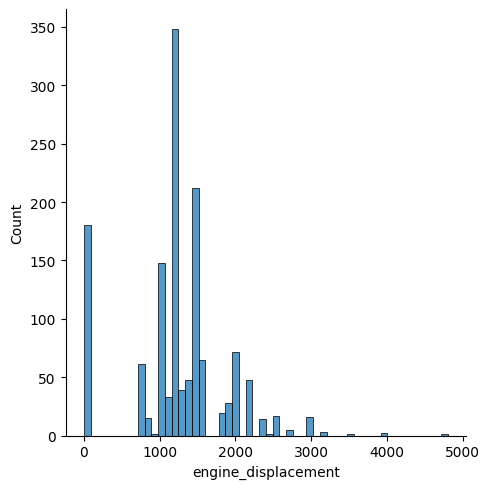

mean: 1234.3144517066087 median: 1198.0


In [30]:
sns.displot(df['engine_displacement'])
plt.show()
print('mean:',df['engine_displacement'].mean(),'median:',df['engine_displacement'].median())

In [31]:
df.fillna({'engine_displacement':df['engine_displacement'].median()},inplace=True)

### Engineering the 'Alloy Wheel Size' column 

In [32]:
df['alloy_wheel_size']=df['Alloy Wheel Size'].apply(lambda x:str(x).lower())
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
nan    544
16     213
15     170
17     133
14     110
18      71
13      68
r15     18
r16     15
19      12
12      10
r17     10
r18      6
20       1
Name: count, dtype: int64

In [33]:
al=[]
for i in list(df['alloy_wheel_size']):
    if i=='nan':
        al.append(np.nan)
    elif i[0]!='r':
        al.append(f'r{i}')
    else:
        al.append(i)
df['alloy_wheel_size']=al
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
r16    228
r15    188
r17    143
r14    110
r18     77
r13     68
r19     12
r12     10
r20      1
Name: count, dtype: int64

In [34]:
df.fillna({'alloy_wheel_size':'r16'},inplace=True)

In [35]:
df['alloy_wheel_size'].isnull().sum()

0

### Engineering the 'Turbo Charger' column

In [36]:
df['turbo_charger']=df['Turbo Charger'].apply(lambda x:str(x).lower())
print(df['turbo_charger'].value_counts())

turbo_charger
no       777
yes      421
nan      177
twin       5
turbo      1
Name: count, dtype: int64


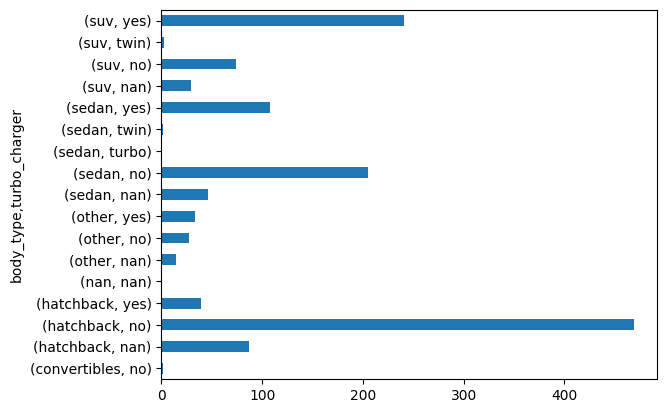

In [37]:
df.groupby(['body_type','turbo_charger'])['turbo_charger'].count().plot(kind='barh')
plt.show()

In [38]:
z=list(df[df['turbo_charger']=='nan']['body_type'])
z

['suv',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'other',
 'other',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'other',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'other',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'suv',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'sedan',
 'other',
 'hatchback',
 'hatchback',
 'sedan',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'other',
 'hatchback',
 'sedan',
 'other',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'sedan',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'other',
 'hatchback',
 'suv',
 '

In [39]:
for h in range(len(z)):
    if z[h]=='suv' or z[h]=='other':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='yes'
    elif z[h]=='hatchback' or z[h]=='sedan':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='no'

In [40]:
df['turbo_charger'].isnull().sum()

0

### Engineering the 'Front Brake Type' column

In [41]:
df.columns

Index(['bt', 'owner', 'oem', 'Registration Year', 'Engine Displacement',
       'Seating Capacity', 'Alloy Wheel Size', 'Turbo Charger', 'Engine',
       'Front Brake Type', 'Gear Box', 'Height', 'Kerb Weight', 'Length',
       'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base',
       'Width', 'kms', 'price_new', 'No Door Numbers', 'No of Cylinder',
       'Values per Cylinder', 'body_type', 'registration_year',
       'seating_capacity', 'engine_displacement', 'alloy_wheel_size',
       'turbo_charger'],
      dtype='object')

In [42]:
df['front_brake_type']=df['Front Brake Type'].apply(lambda x:str(x).lower())
print(df['front_brake_type'].value_counts())

front_brake_type
disc                                        850
ventilated disc                             432
solid disc                                   29
disc                                         16
nan                                          15
ventilated discs                              8
disk                                          7
ventilated disc                               4
ventilated disk                               3
 disc                                         3
disc & caliper type                           3
multilateral disc                             2
vantilated disc                               2
disc, 236 mm                                  2
tandem master cylinder with servo assist      1
caliper ventilated disc                       1
ventillated disc                              1
disc brakes                                   1
mechanical-hydraulic dual circuit             1
Name: count, dtype: int64


In [43]:
df['front_brake_type'].unique()

array(['ventilated disc', 'disc', 'disc ',
       'tandem master cylinder with servo assist', 'nan',
       'caliper ventilated disc', 'ventilated discs', 'disk',
       'multilateral disc', 'solid disc', 'vantilated disc',
       'ventilated disk', 'ventilated disc ', ' disc', 'disc, 236 mm',
       'ventillated disc', 'disc & caliper type', 'disc brakes',
       'mechanical-hydraulic dual circuit'], dtype=object)

In [44]:
df['front_brake_type']=df['front_brake_type'].map({'disc':'solid disc','ventilated disc':'ventilated discs',
                                                   'ventilated discs':'ventilated discs','disc ':'solid disc',
                                                   'solid disc':'solid disc','disk':'solid disc','ventilated disk':'ventilated discs',
                                                   'ventilated disc ':'ventilated discs','vantilated disc':'ventilated discs',
                                                   'ventlated disc':'ventilated discs','disc, 236 mm':'solid disc','nan':'solid disc',
                                                   'drum':'other','multilateral disc':'other','disc & caliper type':'other',
                                                   'booster assisted ventilated disc':'other','caliper ventilated disc':'other',
                                                   'abs':'other'})
print(df['front_brake_type'].value_counts())

front_brake_type
solid disc          919
ventilated discs    449
other                 6
Name: count, dtype: int64


### Engineering the 'Gear Box' column

In [45]:
df['gear_box']=df['Gear Box'].apply(lambda x:str(x).lower())
print(df['gear_box'].value_counts())

gear_box
5 speed                                            758
6 speed                                            201
5-speed                                             81
6-speed                                             51
5 speed                                             40
7 speed                                             33
cvt                                                 26
8 speed                                             26
6 speed                                             22
nan                                                 19
9 speed                                             18
5                                                   17
7-speed dct                                          8
4 speed                                              8
7-speed                                              5
5 speed cvt                                          5
ags                                                  4
8-speed                                              4
7

In [46]:
df['gear_box'].unique()

array(['6 speed ', '5-speed', '5 speed', '7-speed s-tronic ', '6-speed',
       'cvt', '6 speed', 'nan', '9 speed', '9-speed automatic',
       '5 speed cvt', '5 speed ', '5 speed manual', '8-speed steptronic',
       '8 speed', '7 speed', 'ivt', '4-speed', '9 -speed', '8', '5',
       '8-speed', 'imt', '7-speed', '4 speed', '6 speed imt',
       '7 speed dct', '8-speed ', '6-speed dct', 'ags', '7-speed stronic',
       '7 speed 7g-dct', '4 speed ', 'mercedes benz 7 speed automatic',
       '7-speed dct', '8-speed steptronic sport automatic transmission',
       '8 speed sport', '6-speed imt', '8-speed tiptronic',
       '7-speed s tronic', '8-speed automatic transmission', '9g tronic',
       '9-speed', 'ecvt', '6 speed ivt', 'single speed',
       '6 speed with sequential shift', '5-speed`', '7-speed s-tronic',
       '8 speed ', '7 speed cvt', '6-speed ivt',
       'five speed manual transmission gearbox'], dtype=object)

In [47]:
gb=[]
for i in list(df['gear_box']):
    if i=='5 speed' or i=='5-speed' or i=='5 speed ' or i=='5' or i=='five speed' :
        gb.append('5 speed')
    elif i=='five speed manual transmission gearbox' :
        gb.append('5 speed manual transmission')
    elif i=='five speed manual transmission':
        gb.append('5 speed manual transmission')
    elif i in ['7 speed ','7-speed']:
        gb.append('7 speed')
    elif i in ['7-speed stronic','7-speed s-tronic','7-speed s-tronic ']:
        gb.append('7-speed s-tronic')
    elif i in [ '7 speed dct','7-speed dct']:
        gb.append( '7 speed dct')
    elif i in ['8-speed','8', '8-speed ','8 speed ']:
        gb.append('8 speed')
    elif i in ['6 speed ','6-speed','6']:
        gb.append('6 speed')
    elif i in ['6-speed at','6-speed at' ,'6 speed at',]:
        gb.append('6-speed at')
    elif i in ['six speed manual',]:
        gb.append('6-speed manual') 
    else:
        gb.append(i)
        

In [48]:
df['gear_box']=gb
print(df['gear_box'].value_counts())

gear_box
5 speed                                            896
6 speed                                            274
7 speed                                             38
8 speed                                             33
cvt                                                 26
nan                                                 19
9 speed                                             18
7 speed dct                                         12
4 speed                                              8
7-speed s-tronic                                     5
5 speed cvt                                          5
ags                                                  4
9-speed automatic                                    4
ivt                                                  3
4 speed                                              3
7 speed 7g-dct                                       3
5 speed manual transmission                          3
6-speed imt                                          2
6

In [49]:
x=list(df['gear_box'])
gb1=['other' if x.count(i)<10 else i for i in x ]

In [50]:
df['gear_box']=gb1
print(df['gear_box'].value_counts())

gear_box
5 speed        896
6 speed        274
other           65
7 speed         38
8 speed         33
cvt             26
nan             19
9 speed         18
7 speed dct     12
Name: count, dtype: int64


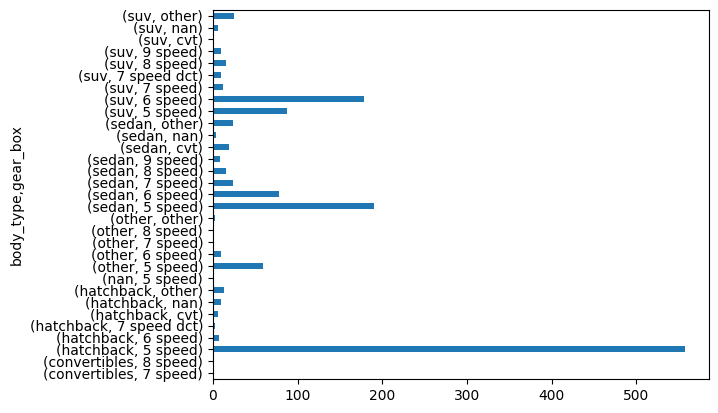

In [51]:
df.groupby(['body_type','gear_box'])['gear_box'].count().plot(kind='barh')
plt.show()

In [52]:
df.fillna({'gear_box':'5 speed'},inplace=True)

In [53]:
df['gear_box'].isnull().sum()

0

### Engineering the 'Mileage' column

In [54]:
df['mileage']=df['Mileage'].apply(lambda x:str(x).lower())
print(df['mileage'].value_counts())

mileage
18.9 kmpl     56
nan           47
18.6 kmpl     29
17.4 kmpl     28
22.05 kmpl    27
              ..
25.47 kmpl     1
22.61 kmpl     1
15.64 kmpl     1
24.04 kmpl     1
19.72 kmpl     1
Name: count, Length: 307, dtype: int64


In [55]:
avs=[]
for i in list(df['mileage']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['mileage']=avs
df['mileage'].value_counts()

mileage
18.0    176
19.0    173
17.0    141
22.0    126
21.0    121
20.0    116
16.0     97
15.0     73
23.0     59
24.0     46
13.0     43
14.0     41
25.0     34
26.0     24
12.0     23
27.0     15
11.0      9
28.0      5
33.0      5
10.0      2
36.0      1
30.0      1
9.0       1
8.0       1
34.0      1
Name: count, dtype: int64

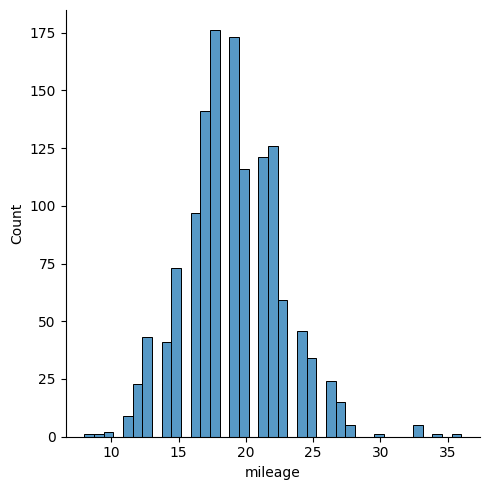

mean: 19.05697151424288 median: 19.0


In [56]:
sns.displot(df['mileage'])
plt.show()
print('mean:',df['mileage'].mean(),'median:',df['mileage'].median())

In [57]:
df.fillna({'mileage':df['mileage'].median()},inplace=True)

In [58]:
df['mileage'].isnull().sum()

0

### Engineering the 'Wheel Base' column

In [59]:
df['wheel_base' ]=df['Wheel Base' ].apply(lambda x:str(x).lower())
print(df['wheel_base' ].value_counts())

wheel_base
2600mm      89
2360mm      84
2380mm      73
2425mm      72
2450        54
            ..
2825mm       1
2,480 mm     1
2440mm       1
2835mm       1
2175mm       1
Name: count, Length: 149, dtype: int64


In [60]:
avs=[]
for i in list(df['wheel_base']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['wheel_base']=avs
df['wheel_base'].value_counts()

wheel_base
2600.0    101
2360.0     98
2450.0     96
2380.0     88
2425.0     73
         ... 
2670.0      1
2647.0      1
3157.0      1
2593.0      1
2175.0      1
Name: count, Length: 105, dtype: int64

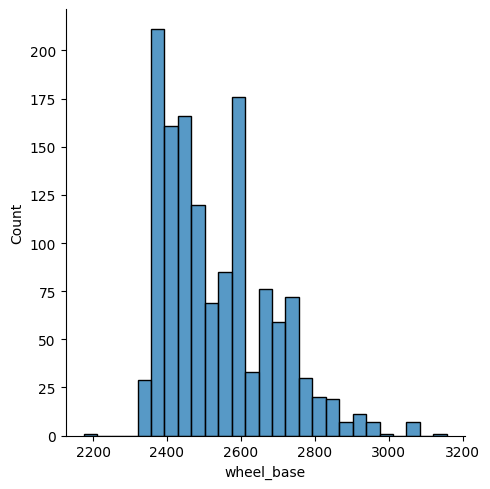

mean: 2537.5753122703895 median: 2501.0


In [61]:
sns.displot(df['wheel_base'])
plt.show()
print('mean:',df['wheel_base'].mean(),'median:',df['wheel_base'].median())

In [62]:
df.fillna({'wheel_base':df['wheel_base'].median()},inplace=True)

In [63]:
df['wheel_base'].isnull().sum()

0

### Engineering the 'Height' column

In [64]:
df['height' ]=df['Height'].apply(lambda x:str(x).lower())
print(df['height'].value_counts())

height
1475mm     103
1495mm      70
1520mm      68
1505mm      49
1530mm      42
          ... 
1429 mm      1
1288mm       1
1600mm       1
1487mm       1
1405mm       1
Name: count, Length: 197, dtype: int64


In [65]:
avs=[]
for i in list(df['height']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['height']=avs
df['height'].value_counts()

height
1475.0    117
1520.0     91
1495.0     72
1505.0     62
1530.0     54
         ... 
1390.0      1
1976.0      1
1370.0      1
1508.0      1
1617.0      1
Name: count, Length: 156, dtype: int64

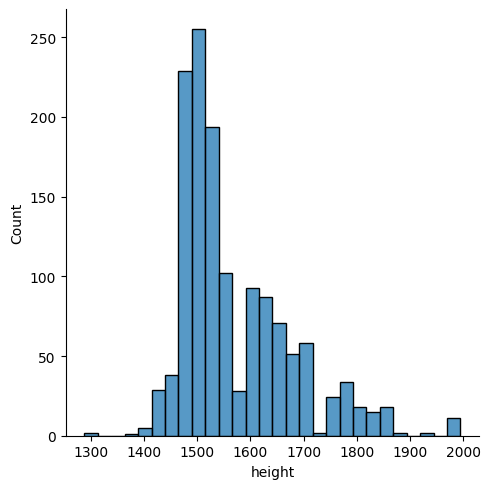

mean: 1569.6712929145363 median: 1530.0


In [66]:
sns.displot(df['height'])
plt.show()
print('mean:',df['height'].mean(),'median:',df['height'].median())

In [67]:
df.fillna({'height':df['height'].median()},inplace=True)

### Engineering the 'Kerb Weight' column

In [68]:
df['kerb_weight' ]=df['Kerb Weight'].apply(lambda x:str(x).lower())
print(df['kerb_weight'].value_counts())
df['kerb_weight'].unique()

kerb_weight
935kg      24
960        19
720kg      19
1120       18
870kg      18
           ..
835         1
847kg       1
890         1
1064 kg     1
1350        1
Name: count, Length: 445, dtype: int64


array(['1625kg', '770', '1055', '1020', '1660kg', '830-845kg', '1070',
       '730', '1025kg', '860kg', '970kg', '710', '1700', '910kg', '2280',
       '810-835', '1120', '1551 kgs', '1775', '784kg', '1200', '1010kg',
       '1085kg', '1060', '1300', '875-905', '1280', '840kg', '805-825kg',
       '1805', '1105kg', '1084kg', '1650 kgs', '970', '865-890', '1210kg',
       '1360', '1080kg', '950kg', '1205kg', '750', '854kg', '1455kg',
       '1240kg', '1660', '2027', '1225kg', '1230', '1044kg', '1165kg',
       '1030', '905', '1061kg', '1345', '930', '1104kg', '1180', '1329kg',
       '880-915', '870kg', '1610kg', '885kg', '1235kg', '705kg', '935',
       '1050', '1025', '1389kg', '845kg', '835kg', '1830kg', '860-895kg',
       '1600kg', '2115kg', '1180kg-1270kg', '1825kg', '1595', '1040',
       '690', '1880kg', '1270', '805', '1776kg', '1875', '1058kg', '1250',
       '1,585 kg', '1675 kg', '1065kg', '935kg', '825', '1066kg',
       '1135-1170', '1210', '925kg', '1400', '1450', '990', 

In [69]:
avs=[]
for i in list(df['kerb_weight']):
    if i=='nan' or i=='kerb weight':
        avs.append(np.nan)
    
    elif i[0].isnumeric()==True:
        
        b=[]
        if '-' in list(i):
            r=i.index('-')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['kerb_weight']=avs
df['kerb_weight'].value_counts()

kerb_weight
860.0     31
880.0     29
960.0     28
935.0     27
1100.0    26
          ..
1680.0     1
1780.0     1
1355.0     1
1495.0     1
1350.0     1
Name: count, Length: 307, dtype: int64

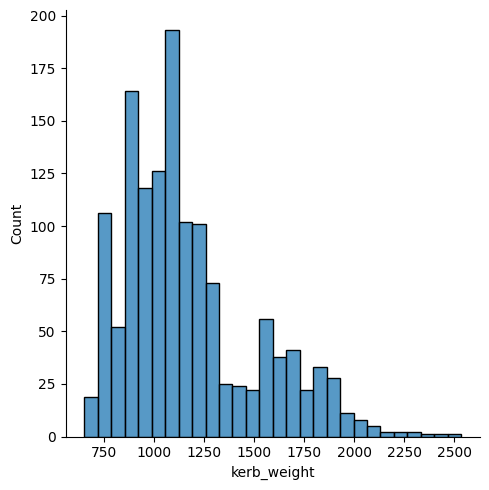

mean: 1166.671511627907 median: 1095.0


In [70]:
sns.displot(df['kerb_weight'])
plt.show()
print('mean:',df['kerb_weight'].mean(),'median:',df['kerb_weight'].median())

In [71]:
df.fillna({'kerb_weight':df['kerb_weight'].median()},inplace=True)

### Engineering the 'Length' column

In [72]:
df['length' ]=df['Length'].apply(lambda x:str(x).lower())
print(df['length'].value_counts())
df['length'].unique()

length
3995mm    129
4440mm     83
3765mm     53
3585mm     37
4585mm     35
         ... 
4420mm      1
4820mm      1
4755mm      1
4797mm      1
3335mm      1
Name: count, Length: 212, dtype: int64


array(['4825mm', '3429mm', '3991mm', '3940 mm', '4385mm', '3655 mm',
       '3610 mm', '3679mm', '4160mm', '3595mm', '3850mm', '3731mm',
       '3585mm', '4598mm', '3995mm', '4795mm', '3655mm', '4395mm',
       '4371 mm', '3545mm', '3993', '4490mm', '4440mm', '3805mm',
       '4270mm', '3845mm', '3715mm', '3765mm', '5063mm', '4425mm',
       '4585 mm', '4545mm', '4300mm', '3746mm', '3990mm', '4386mm',
       '3565mm', '4520mm', '4560mm', '4936mm', '4882mm', '4453mm',
       '3999mm', '3955mm', '4370mm', '3695mm', '3610mm', '4915mm',
       '4325mm', '4530mm', '4570mm', '4591mm', '3599mm', '4265mm',
       '3495mm', '3700mm', '4569mm', '3600mm', '4629mm', '3500mm',
       '4585mm', '4879mm', '4540mm', '4661mm', '4705mm', '4375mm',
       '4637mm', '4644mm', '4,435 mm', '4,580 mm', '3985mm', '4395 mm',
       '4315mm', '4405mm', '4797mm', '4985mm', '3840mm', '3955 mm',
       '4655mm', '4413mm', '3435mm', '4620mm', '3775mm', '3445', '3993mm',
       '3636mm', '4456mm', '4445mm', '4300', 

In [73]:
avs=[]
for i in list(df['length']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['length']=avs
df['length'].value_counts()

length
3995.0    152
4440.0     87
3765.0     55
3585.0     37
4585.0     36
         ... 
3988.0      1
4841.0      1
3989.0      1
4823.0      1
3335.0      1
Name: count, Length: 187, dtype: int64

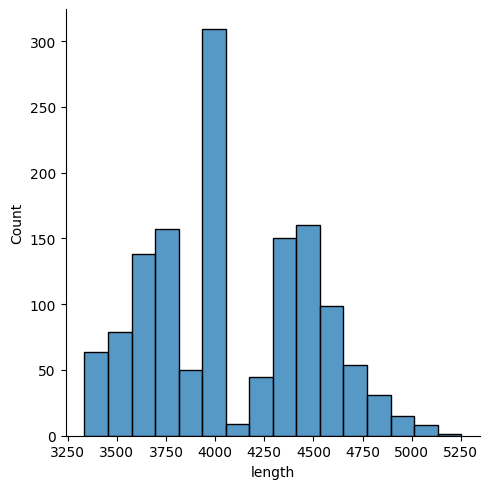

mean: 4080.217677136596 median: 3995.0


In [74]:
sns.displot(df['length'])
plt.show()
print('mean:',df['length'].mean(),'median:',df['length'].median())

In [75]:
df.fillna({'length':df['length'].median()},inplace=True)

### Engineering the 'Max Power' column

In [76]:
df['max_power']=df['Max Power'].apply(lambda x:str(x).lower())
print(df['max_power'].value_counts())
df['max_power'].unique()

max_power
81.86bhp     56
81.80bhp     46
121.3bhp     39
88.50bhp     37
82bhp        33
             ..
76.8bhp       1
258bhp        1
178.49bhp     1
204bhp        1
186bhp        1
Name: count, Length: 256, dtype: int64


array(['158.2bhp', '53.64bhp', '71.01bhp', '80 ps at 5200 rpm',
       '174.33bhp', '81.80bhp', '68.05bhp', '53.3bhp', '85.8bhp',
       '67.1bhp', '53.26bhp', '167.67bhp', '83.1bhp', '174.5bhp',
       '65.71bhp', '170bhp', '245.4bhp', '67.05bhp', '118.35bhp',
       '91.1bhp', '117.3bhp', '81.86bhp', '121.3bhp', '88.50bhp',
       '113.18bhp', '67.04bhp', '191.7bhp', '105.5bhp', '90ps at 4000rpm',
       '117.6bhp', '121bhp', '132 ', '69bhp', '86.7bhp', '105bhp',
       '67bhp', '62bhp', '181bhp', '88.7bhp', '187.74bhp', '268bhp',
       '110.4bhp', '98.6bhp', '68.07bhp', '55.92bhp', '86.8bhp',
       '78.9bhp', '75 ps ', '147.5bhp', '149.92bhp', '88.76bhp',
       '46.3bhp', '82bhp', '68bhp', '86.83bhp', '108.5bhp', '126.2bhp',
       '174.3bhp', '66.1bhp', '100.6bhp', '296bhp', '138bhp', '152.87bhp',
       '168.5bhp', '62.1bhp', '190bhp', '215bhp', '80 ', '102',
       '81.83bhp', '103.26bhp', '102.53bhp', '113.43bhp', '108.62bhp',
       '247bhp', '215.01bhp', '141bhp', '55.2bhp'

In [77]:
a=[]
for i in list(df['max_power']):
    if 'bhp' not in i:
        a.append(i)
print(set(a))

{'85ps ', '102', '57.5', '52 ps ', '75 ps ', 'nan', '118ps at 6,600 rpm', '68ps ', '132 ', '90(66) ', '80 ps at 5200 rpm', '78 ', '75 ps at 4000 rpm ', '88.2', '80 ', '47', '68', '170 ', '110 ', '65', '90ps at 4000rpm', '60 ps ', '161.6 ', '94 '}


In [78]:
avs=[]
for i in list(df['max_power']):
    if i=='nan':
        avs.append(np.nan)
    elif i=='66(90) / 4000' or i=='90(66) ':
        avs.append(65)
    elif i=='118ps at 6,600 rpm':
        avs.append(116.39)
    elif i=='105 ps at 5250 rpm':
        avs.append(103.56)
    elif i=='90ps at 4000rpm':
        avs.append(78.91)
    elif i=='80 ps at 5200 rpm':
        avs.append(99.77)
    elif i=='63 hp at 3200 rpm':
        avs.append(63)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['max_power']=avs
df['max_power'].value_counts()

max_power
82.0     144
67.0      95
117.0     57
47.0      57
88.0      55
        ... 
247.0      1
182.0      1
63.0       1
296.0      1
186.0      1
Name: count, Length: 128, dtype: int64

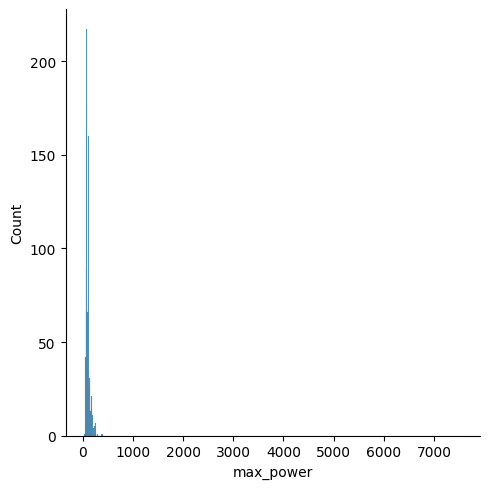

mean: 108.12938730853392 median: 88.0


In [79]:
sns.displot(df['max_power'])
plt.show()
print('mean:',df['max_power'].mean(),'median:',df['max_power'].median())

In [80]:
df.fillna({'max_power':df['max_power'].median()},inplace=True)

### Engineering the 'Max Torque' column

In [81]:
df['max_torque' ]=df['Max Torque'].apply(lambda x:str(x).lower())
print(df['max_torque' ].value_counts())
df['max_torque' ].unique()

max_torque
90nm@3500rpm          71
145nm@4600rpm         57
69nm@3500rpm          56
114nm@4000rpm         50
200nm@1750rpm         43
                      ..
248nm@2250rpm          1
650nm@1750-4750rpm     1
190nm@1750-3000rpm     1
142nm@4000rpm          1
285nm@2400-4000rpm     1
Name: count, Length: 257, dtype: int64


array(['213nm@4500rpm', '72nm@4386rpm', '96nm@3500rpm',
       '11.4 kgm at 4,000 rpm', '380nm@1750-2500rpm', '113nm@4200rpm',
       '99nm@4500 rpm', '114nm@4000rpm', '90nm@3500rpm', '72nm@4250rpm',
       '99.04nm@4500rpm', '350nm@1750-2500rpm', '115nm@4000rpm',
       '450nm@1600-2400rpm', '89nm@3500rpm', '114.74nm@4200rpm',
       '430nm@1750-2500rpm', '170nm@1750-4000rpm', '130nm@4000rpm',
       '145nm@4600rpm', '113.8nm@4000rpm', '151nm@4850rpm',
       '113nm@4400rpm', '143.8nm@4500rpm', '113.75nm@4000rpm',
       '400nm@1600-2800rpm', '140nm@4200rpm', '22.4 kgm at 1750-2750rpm',
       '300nm@1750-2500rpm', '17.5 @ 4,300 (kgm@rpm)',
       '140nm@1800-3000rpm', '109nm@4500rpm', '250nm@1500-2500rpm',
       '91nm@4250rpm', '96.1nm@3000rpm', '380nm@1750-3000rpm',
       '115nm@4500rpm', '400nm@1750-2500rpm', '400nm@3000rpm',
       '140nm@4400rpm', '110nm@4800rpm', '200nm@1750rpm',
       '99.07nm@4500 rpm', '154.9nm@4200rpm', '82.1nm@3400rpm',
       '111.7nm@4000rpm', '130 nm 

In [82]:
s=[i if '15' in i else 'a' for i in list(df['max_torque'])]
s

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '151nm@4850rpm',
 'a',
 '151nm@4850rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '250nm@1500-2500rpm',
 'a',
 'a',
 'a',
 '115nm@4500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '154.9nm@4200rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@3500-3600rpm',
 'a',
 'a',
 '250nm@1500-2500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '400nm@1500-4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '440nm@1500-3000rpm',
 'a',
 '154.9nm@4200rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '365nm@1500rpm',
 'a',

In [83]:
avs=[]
for i in list(df['max_torque']):
    if i=='nan' :
        avs.append(np.nan)
    elif i=='11.4 kgm at 4,000 rpm':
        avs.append(round(111.79581))
    elif i=='22.4 kgm at 1750-2750rpm':
        avs.append(round(219.67))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(132.38))
    elif i=='180 nm at 1440-1500rpm':
        avs.append(round(180))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(219.87))
    elif i=='155 nm at 1600-2800 rpm':
        avs.append(round(155))  
    elif i=='210 / 1900':
        avs.append(round(210)) 
    elif i=='135 nm @ 2500 rpm ':
        avs.append(round(135)) 
    elif i=='148  nm @ 3500  rpm':
        avs.append(round(148))
    elif i=='146nm at 4800 rpm':
        avs.append(round(146))
    
    elif i[0].isnumeric()==True:
        b=[]
        if '@' in list(i):
            r=i.index('@')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['max_torque']=avs
df['max_torque'].value_counts()

max_torque
114.0    102
113.0     87
90.0      73
145.0     66
200.0     63
        ... 
125.0      1
195.0      1
12.0       1
248.0      1
285.0      1
Name: count, Length: 118, dtype: int64

In [84]:
max(avs)

1901750

In [85]:
# sns.displot(df['max_torque'])
# plt.show()
print('mean:',df['max_torque'].mean(),'median:',df['max_torque'].median())

mean: 1564.803792851933 median: 132.0


In [86]:
df.fillna({'max_torque':df['max_torque'].median()},inplace=True)

### Engineering the 'Width' column

In [87]:
df['width' ]=df['Width'].apply(lambda x:str(x).lower())
print(df['width'].value_counts())
df['width'].unique()

width
1695mm    114
1660mm     62
1680mm     45
1595mm     44
1735mm     38
         ... 
1828mm      1
1805mm      1
1758mm      1
1898mm      1
1440mm      1
Name: count, Length: 179, dtype: int64


array(['1825mm', '1560mm', '1750', '1710 mm', '2019mm', '1620 mm',
       '1645 mm', '1579mm', '1690mm', '1475mm', '1695mm', '1595mm',
       '1894mm', '1745mm', '1855mm', '1620mm', '1775mm', '1818mm',
       '1996 mm', '1515mm', '1811', '1730mm', '1680', '1780mm', '1735',
       '1729mm', '1635mm', '1660mm', '1860mm', '1866 mm', '1750mm',
       '1790mm', '1647mm', '1680mm', '1699mm', '1525mm', '1817mm',
       '2126mm', '1735mm', '1765mm', '1694mm', '1490mm', '1734mm',
       '1700mm', '1655', '2086mm', '1662mm', '1800mm', '1770mm', '1495mm',
       '1755', '1769mm', '2089mm', '1600mm', '1760mm', '2220mm', '1890mm',
       '1579', '1840mm', '2097mm', '2120mm', '1,680 mm', '1,770 mm',
       '1735 mm', '1822mm', '1821mm', '2145mm', '1926mm', '1694 mm',
       '1835mm', '1550mm', '1677', '1710mm', '1574mm', '1515', '1682mm',
       '1820mm', '1785', '1715mm', '1748mm', '1830', '1,726 mm', '1902mm',
       '1642mm', '1520', '1923 mm', '2098mm', '1703mm', '1813mm',
       '1776mm', '1778

In [88]:
avs=[]
for i in list(df['width']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['width']=avs
df['width'].value_counts()

width
1695.0    120
1735.0     77
1680.0     67
1660.0     63
1595.0     44
         ... 
1703.0      1
1828.0      1
1764.0      1
1758.0      1
1440.0      1
Name: count, Length: 136, dtype: int64

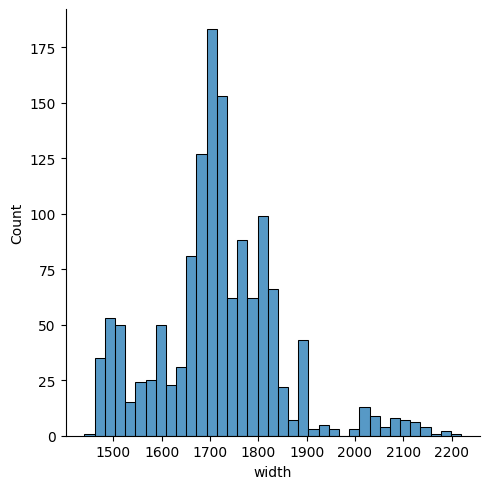

mean: 1716.964207450694 median: 1710.0


In [89]:
sns.displot(df['width'])
plt.show()
print('mean:',df['width'].mean(),'median:',df['width'].median())

In [90]:
df.fillna({'width':df['width'].median()},inplace=True)

In [91]:
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,front_brake_type,gear_box,mileage,wheel_base,height,kerb_weight,length,max_power,max_torque,width
0,Sedan,>2_owners,toyota,2014,2494 cc,5.0,17,No,2494 CC,Ventilated Disc,...,ventilated discs,6 speed,19.0,2775.0,1480.0,1625.0,4825.0,158.00,213.0,1825.0
1,Hatchback,1_owner,datsun,Jul 2017,799 cc,5.0,NaN,No,799 CC,Disc,...,solid disc,5 speed,23.0,2348.0,1541.0,770.0,3429.0,54.00,72.0,1560.0
2,SUV,1_owner,renault,Nov 2021,999 cc,5.0,NaN,NaN,999 CC,Disc,...,solid disc,5 speed,19.0,2500.0,1605.0,1055.0,3991.0,71.00,96.0,1750.0
3,Hatchback,2_owners,hyundai,Feb 2012,1197 cc,5.0,14,No,1197 CC,Disc,...,solid disc,5 speed,17.0,2525.0,1505.0,1020.0,3940.0,99.77,112.0,1710.0
4,SUV,2_owners,audi,2014,1968 cc,5.0,16,Yes,1968 CC,Ventilated Disc,...,ventilated discs,other,16.0,2603.0,1608.0,1660.0,4385.0,174.00,380.0,2019.0


### Checking for null values on the newly engineered columns

In [92]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,1,7,0.000724
owner,object,0,4,0.000000
oem,object,0,18,0.000000
Registration Year,object,0,184,0.000000
Engine Displacement,object,4,91,0.002896
Seating Capacity,float64,3,8,0.002172
Alloy Wheel Size,object,544,13,0.393917
Turbo Charger,object,177,8,0.128168
Engine,object,0,92,0.000000
Front Brake Type,object,15,19,0.010862


In [93]:
df.dropna(subset=['front_brake_type','Rear Brake Type','No of Cylinder','Values per Cylinder'],inplace=True)

These two columns namely 'No of Cylinder','Values per Cylinder' has null values ,so I'm dropping the rows considering these two columns as subset in the entire dataframe

In [94]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})


,dtypes,null_count,unique_values,percent_of_null_values
bt,object,1,7,0.000741
owner,object,0,4,0.000000
oem,object,0,17,0.000000
Registration Year,object,0,182,0.000000
Engine Displacement,object,4,84,0.002963
Seating Capacity,float64,0,8,0.000000
Alloy Wheel Size,object,535,13,0.396296
Turbo Charger,object,156,7,0.115556
Engine,object,0,86,0.000000
Front Brake Type,object,0,14,0.000000


In [95]:
new_all_selected_features=['owner', 'oem','body_type', 'registration_year', 
    'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box',
   'Rear Brake Type','seating_capacity','kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base',
   'height', 'kerb_weight', 'length', 'max_power', 'max_torque','width']
for i in car_features:
    new_all_selected_features.append(i)

In [96]:
df=df[new_all_selected_features]
df.head()

,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
0,>2_owners,toyota,sedan,2014,r17,no,ventilated discs,6 speed,Solid Disc,5,...,2775.0,1480.0,1625.0,4825.0,158.00,213.0,1825.0,4.0,4.0,4.0
1,1_owner,datsun,hatchback,2017,r16,no,solid disc,5 speed,Drum,5,...,2348.0,1541.0,770.0,3429.0,54.00,72.0,1560.0,5.0,3.0,4.0
2,1_owner,renault,suv,2021,r16,nan,solid disc,5 speed,Drum,5,...,2500.0,1605.0,1055.0,3991.0,71.00,96.0,1750.0,5.0,3.0,4.0
3,2_owners,hyundai,hatchback,2012,r14,no,solid disc,5 speed,Drum,5,...,2525.0,1505.0,1020.0,3940.0,99.77,112.0,1710.0,5.0,4.0,4.0
4,2_owners,audi,suv,2014,r16,yes,ventilated discs,other,Drum,5,...,2603.0,1608.0,1660.0,4385.0,174.00,380.0,2019.0,5.0,4.0,4.0


In [97]:
#categorical columns list
cc=[]
#numerical columns list
nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        cc.append(i)
    else:
        nc.append(i)
print('categorical_columns:',cc)
print()
print('numerical_columns:',nc)

categorical_columns: ['owner', 'oem', 'body_type', 'registration_year', 'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box', 'Rear Brake Type', 'seating_capacity']

numerical_columns: ['kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base', 'height', 'kerb_weight', 'length', 'max_power', 'max_torque', 'width', 'No Door Numbers', 'No of Cylinder', 'Values per Cylinder']


### Finding outliers in categorical columns and replacing it with upper and lower limit values respectively

In [98]:
def plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

   # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

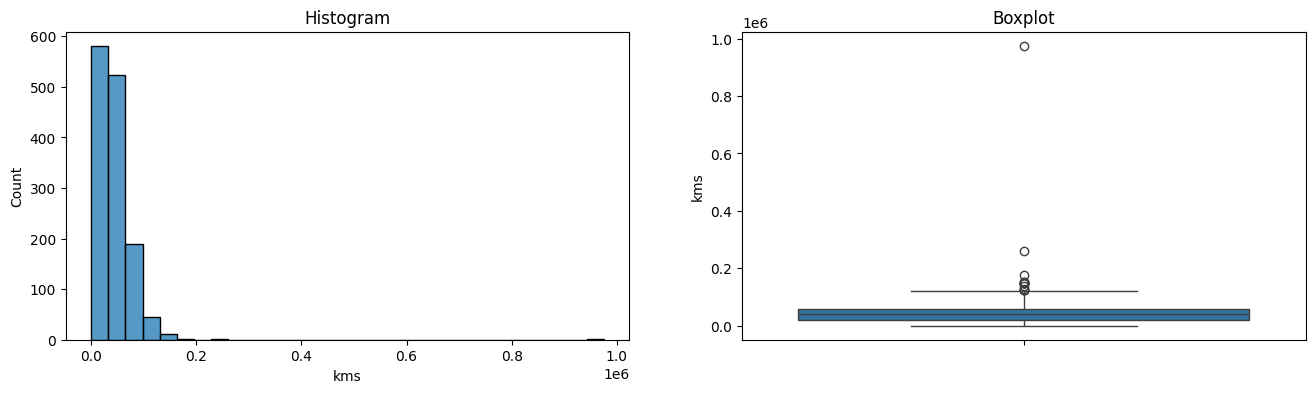

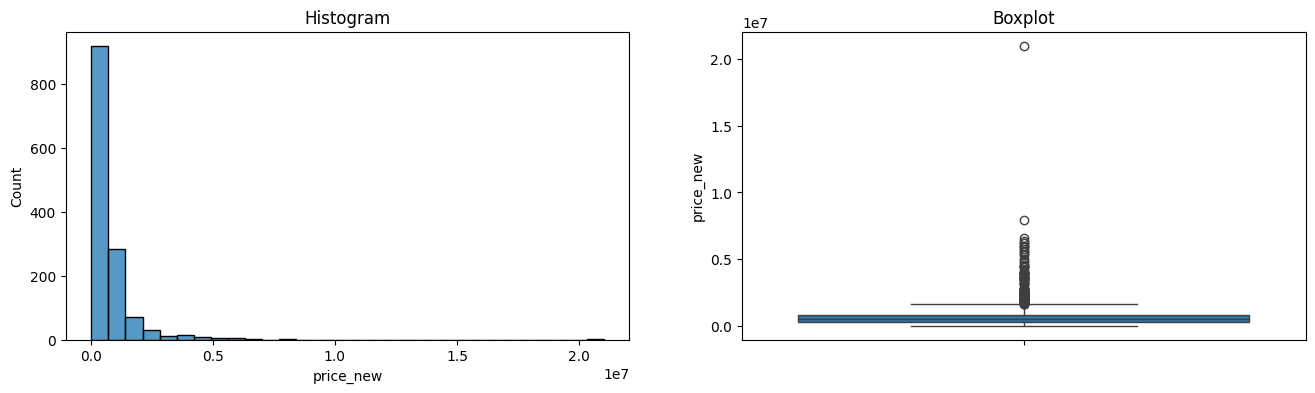

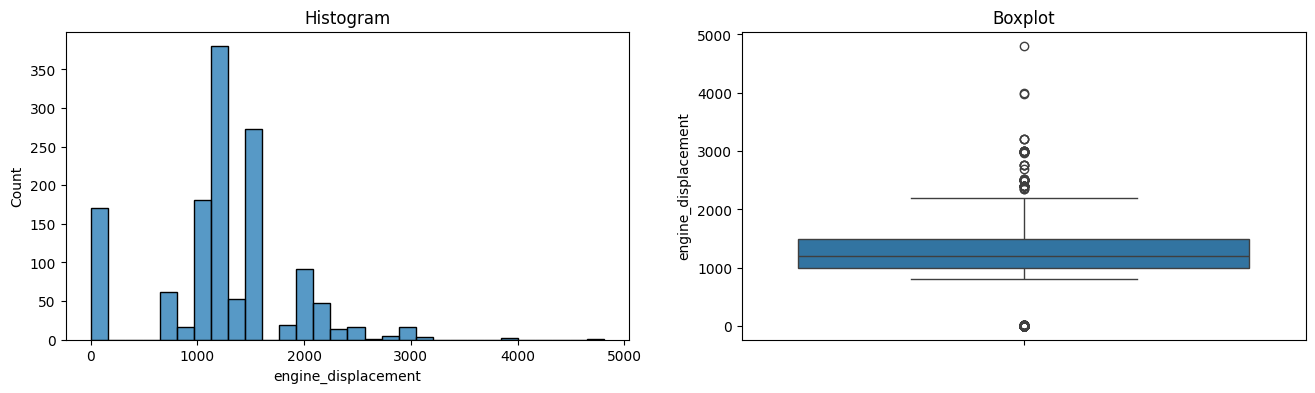

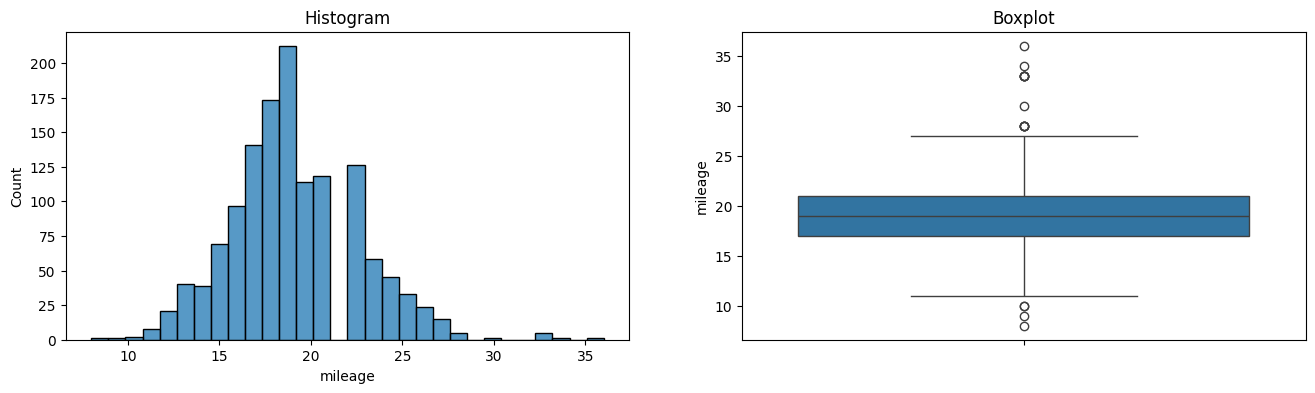

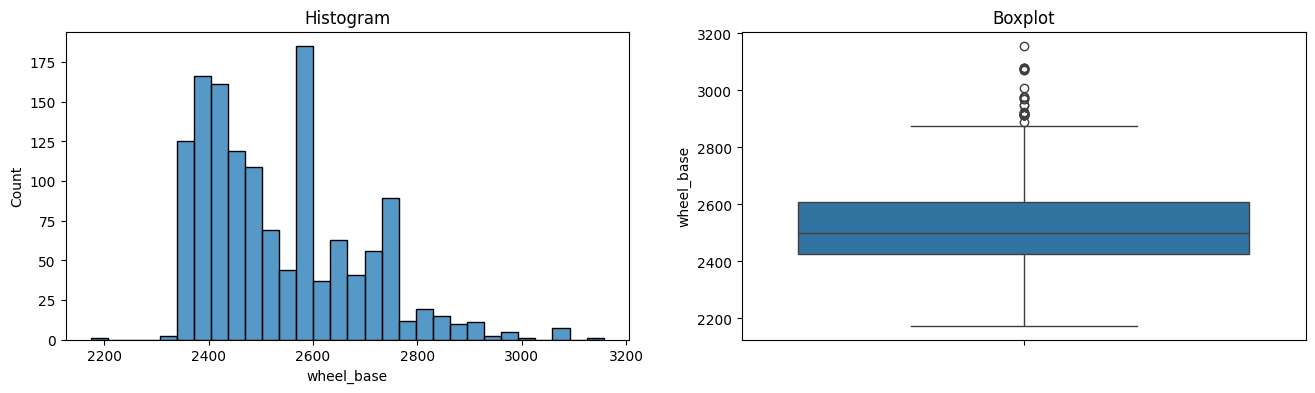

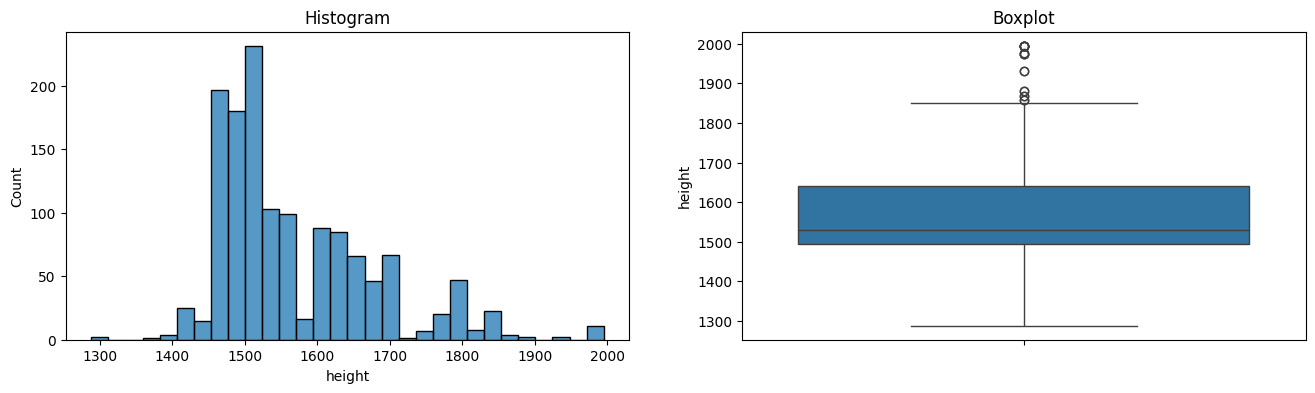

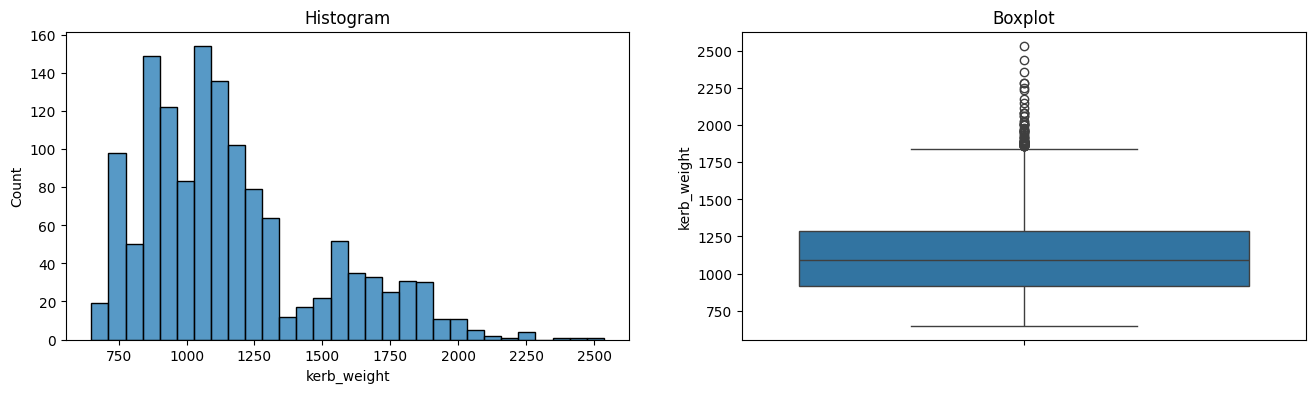

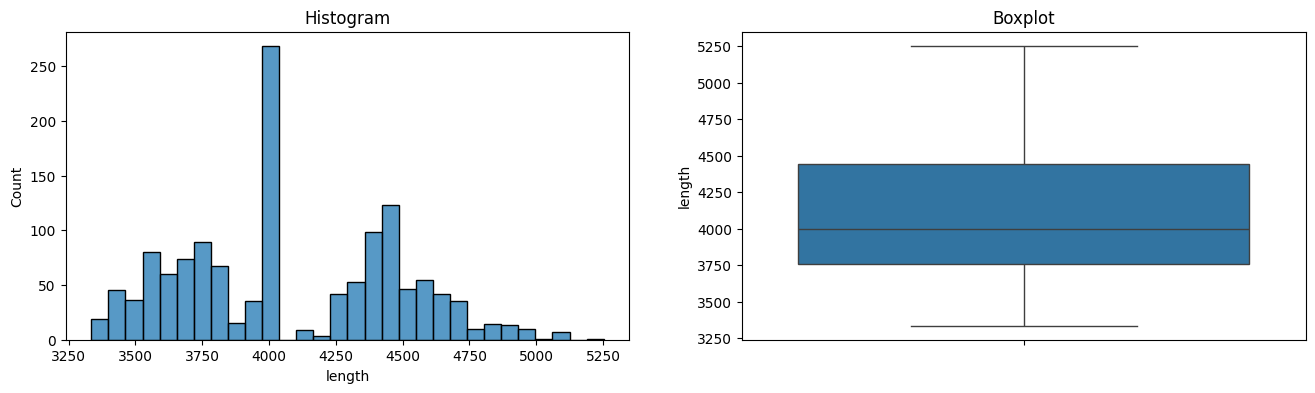

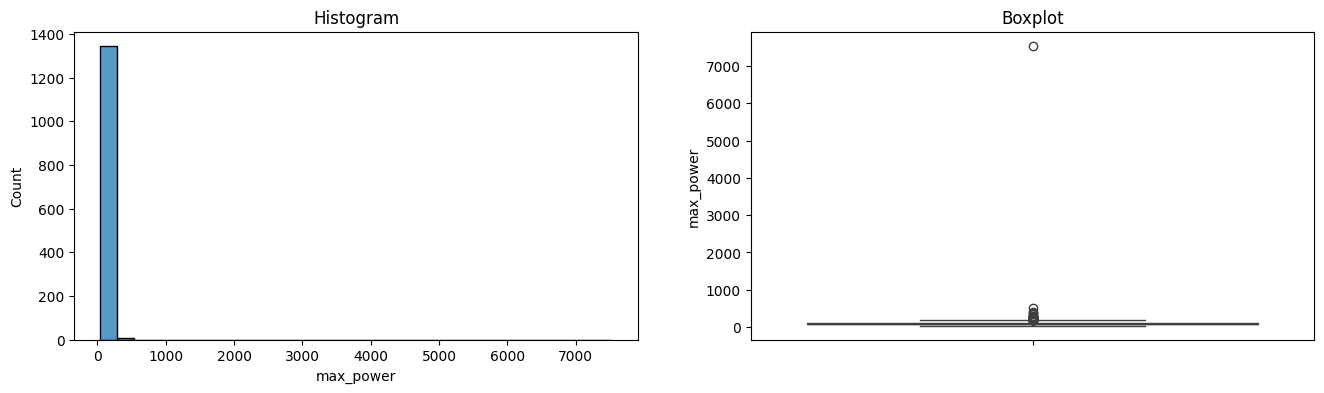

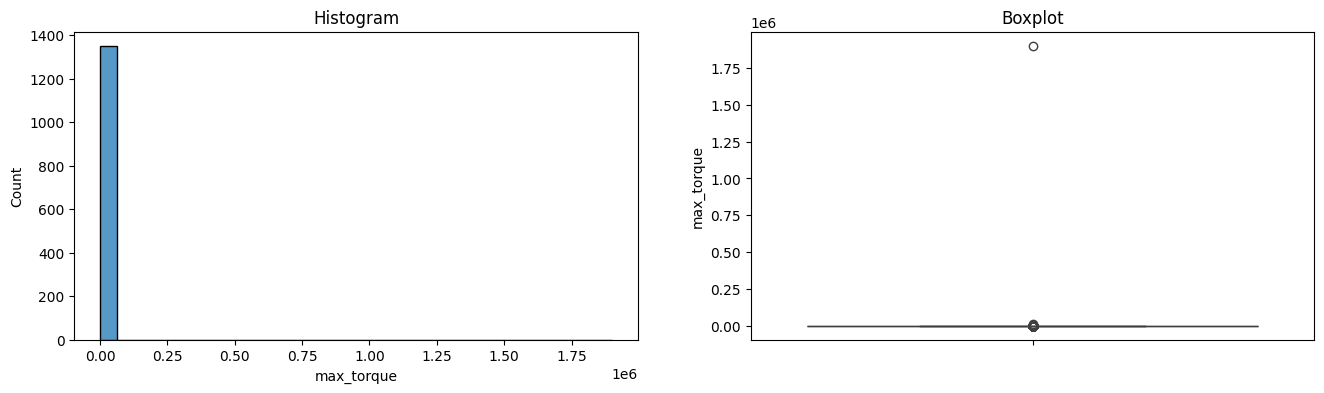

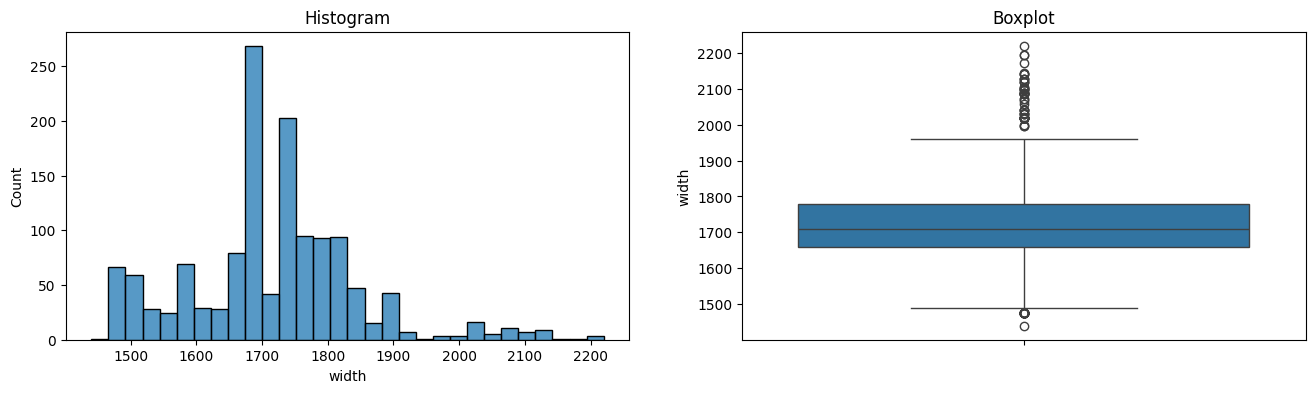

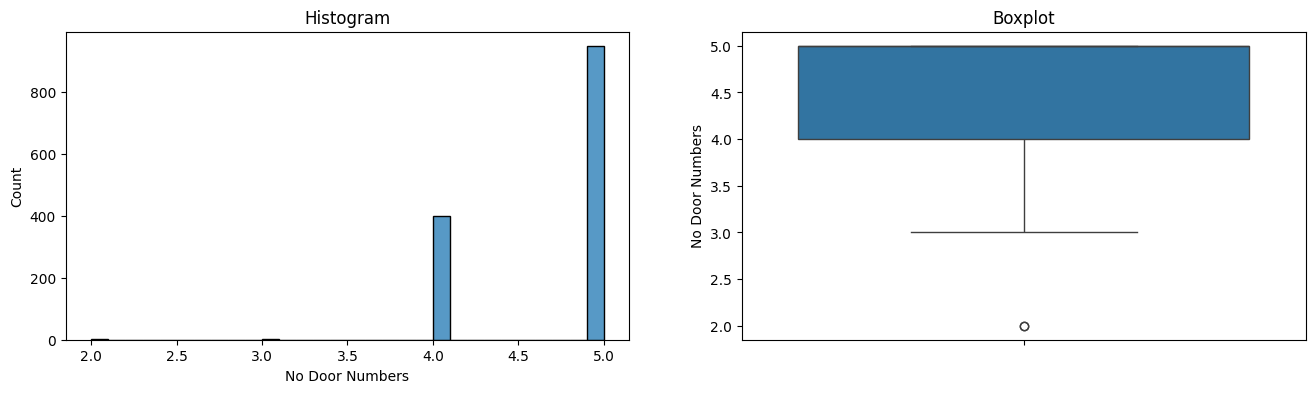

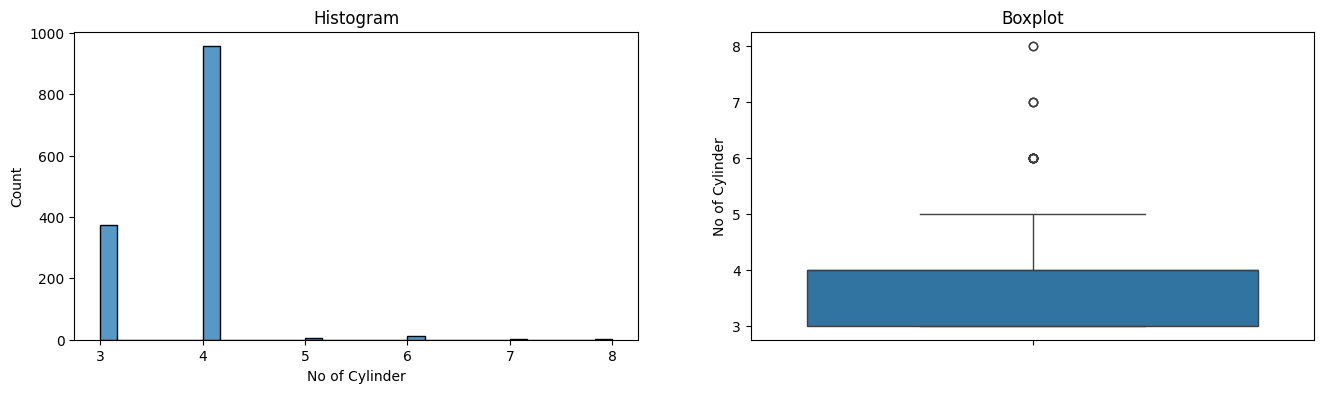

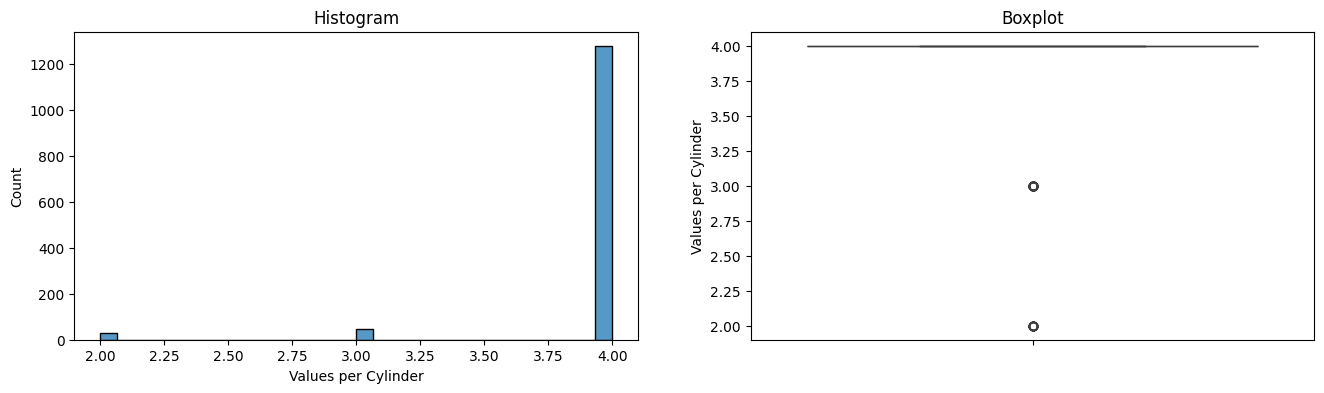

In [99]:
for m in nc:
    plots(df, m)

In [100]:
def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions


    IQR = round(df[variable].quantile(0.75) - df[variable].quantile(0.25))

    lower_boundary = abs(round(df[variable].quantile(0.25) - (IQR * distance)))
    upper_boundary = abs(round(df[variable].quantile(0.75) + (IQR * distance)))

    return upper_boundary, lower_boundary

In [101]:
ul=[]
for v in nc:
    upper_limit, lower_limit = find_skewed_boundaries(df, v, 1.5)
    ul.append((v,upper_limit, lower_limit))

In [102]:
def replace_outlier(dataset,variable,upper_limit,lower_limit):
    dataset[variable]= np.where(dataset[variable] > upper_limit, upper_limit,
                       np.where(dataset[variable] < lower_limit, lower_limit, dataset[variable]))

In [103]:
for v1 in range(len(ul)):
    replace_outlier(df,ul[v1][0],ul[v1][1],ul[v1][2])

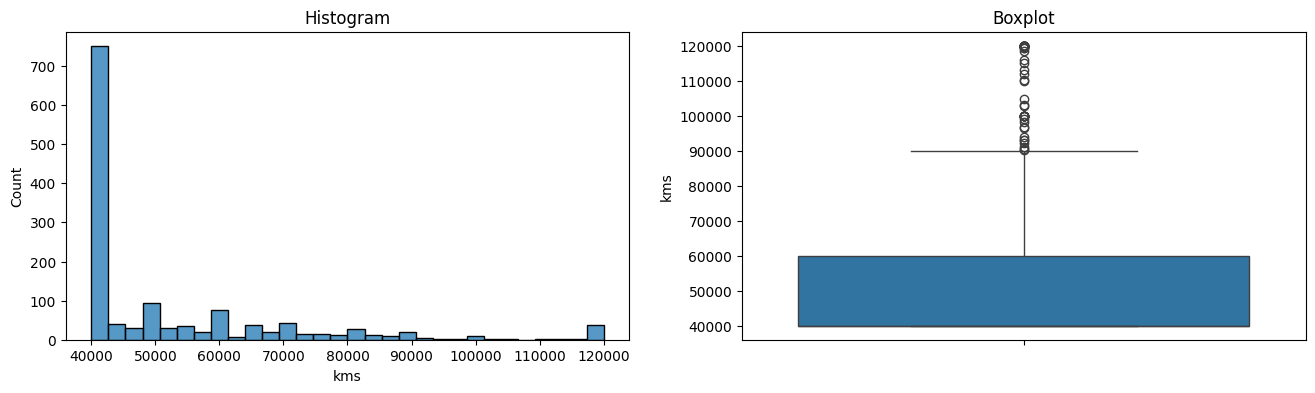

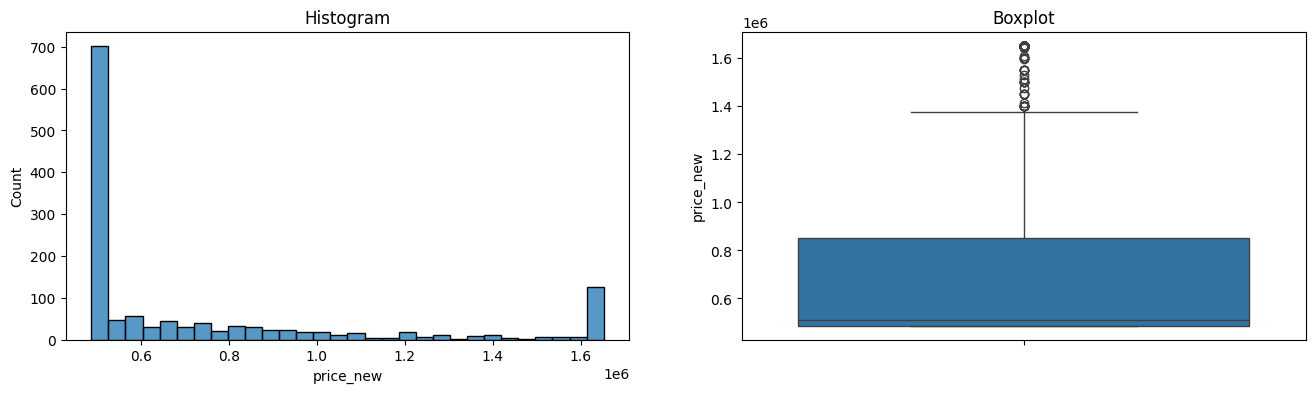

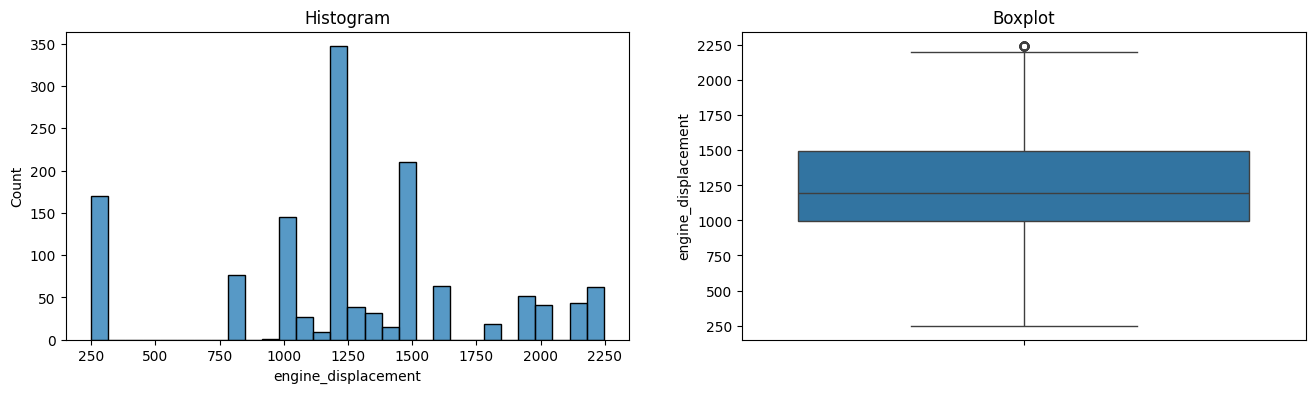

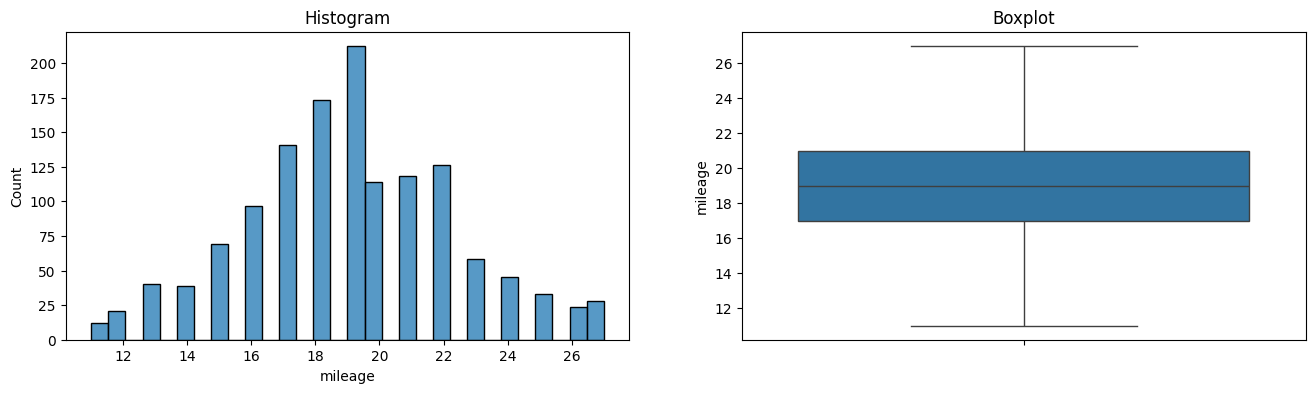

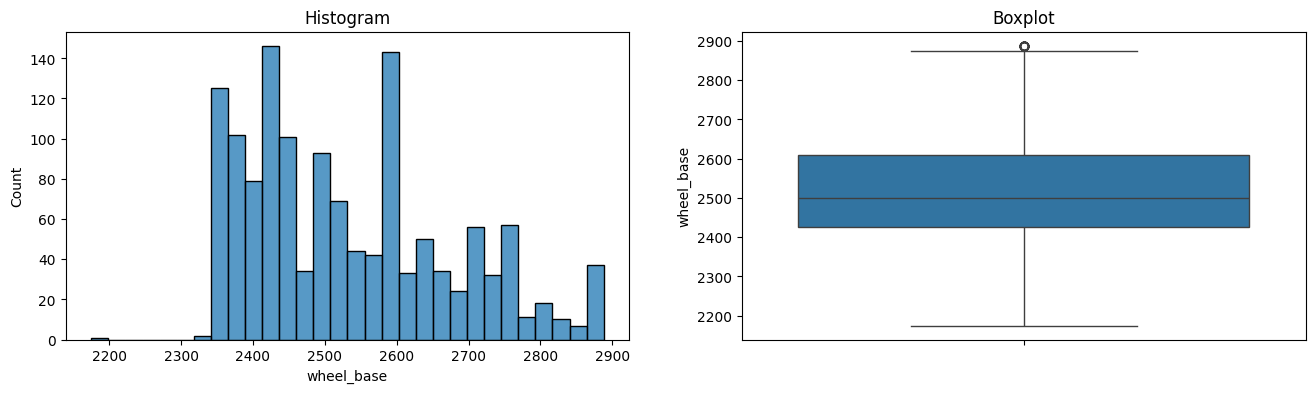

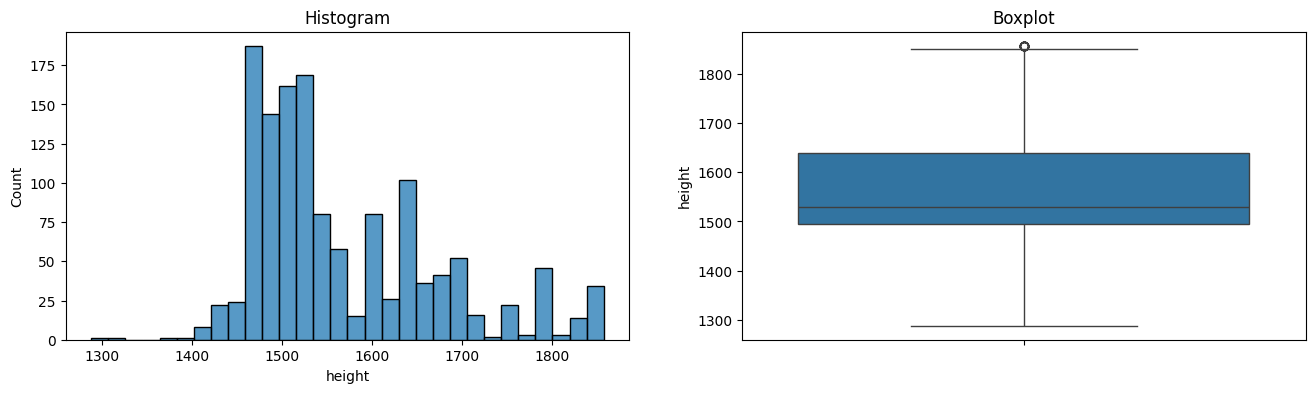

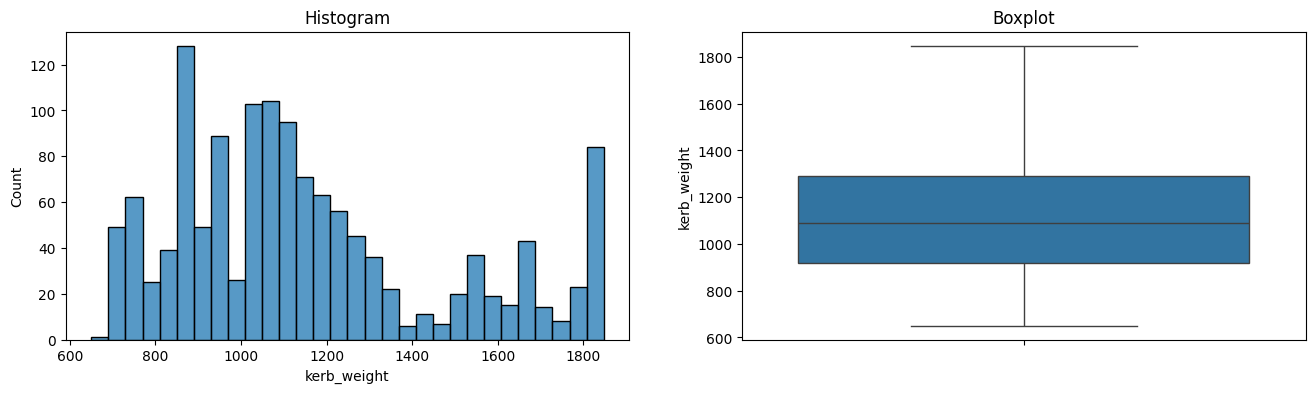

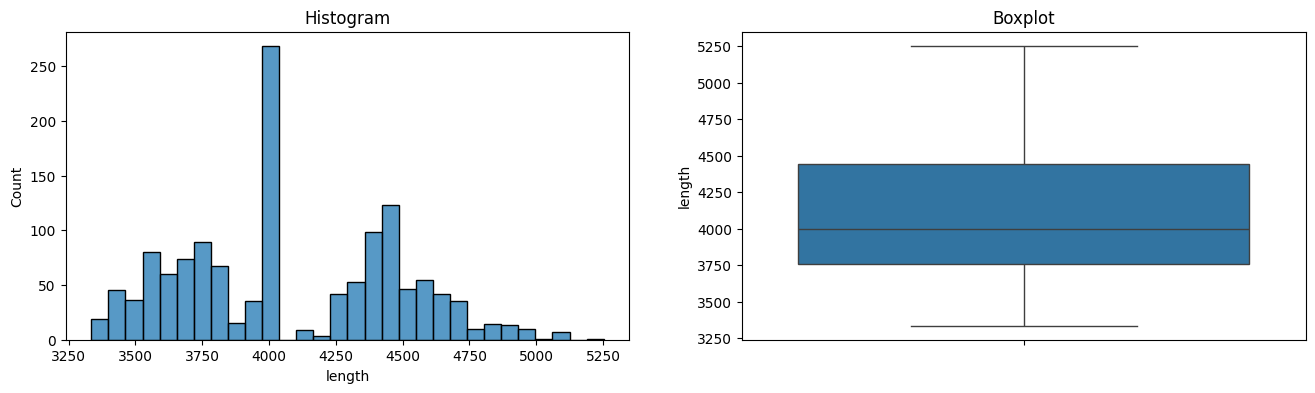

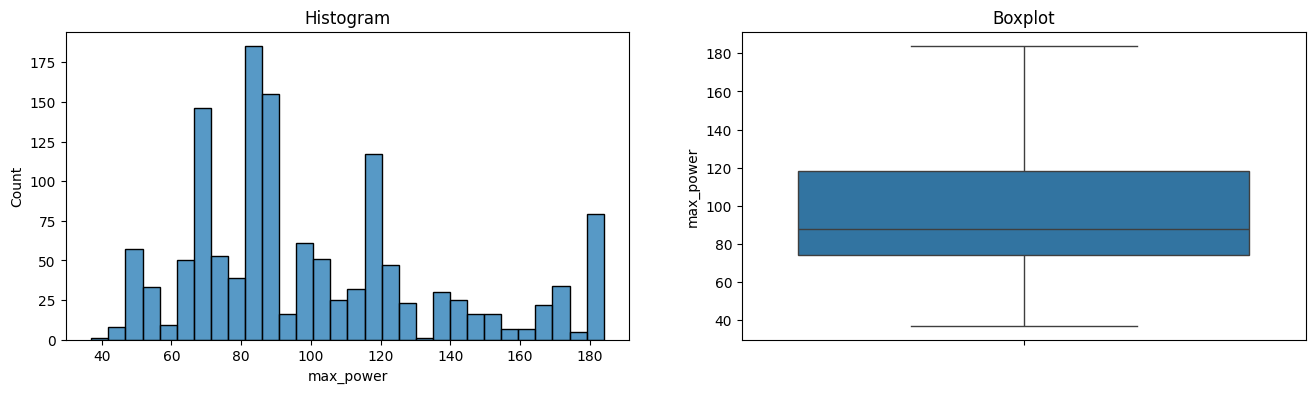

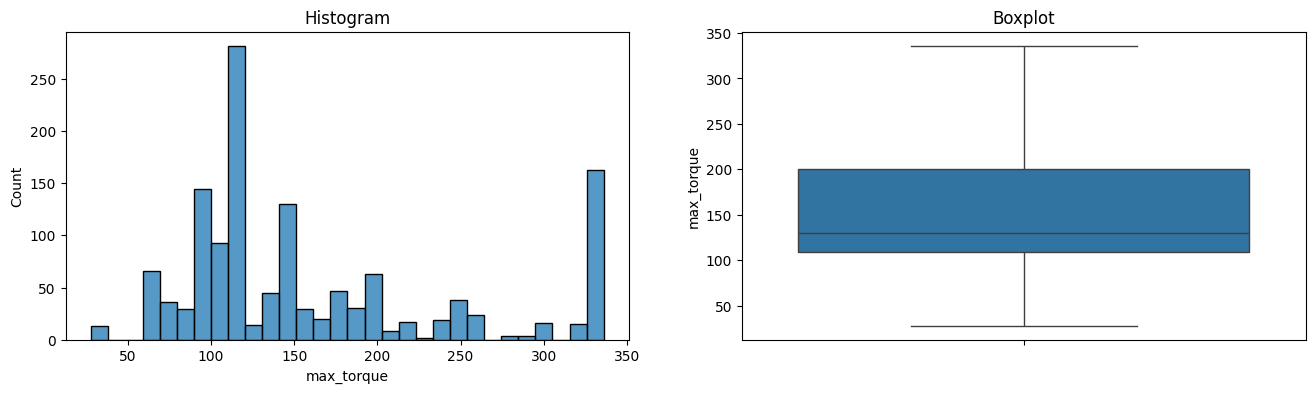

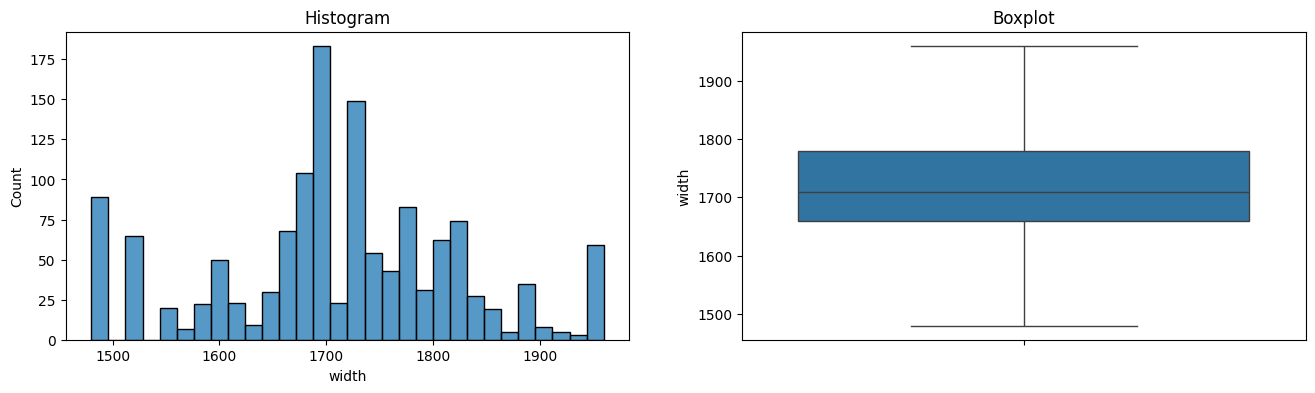

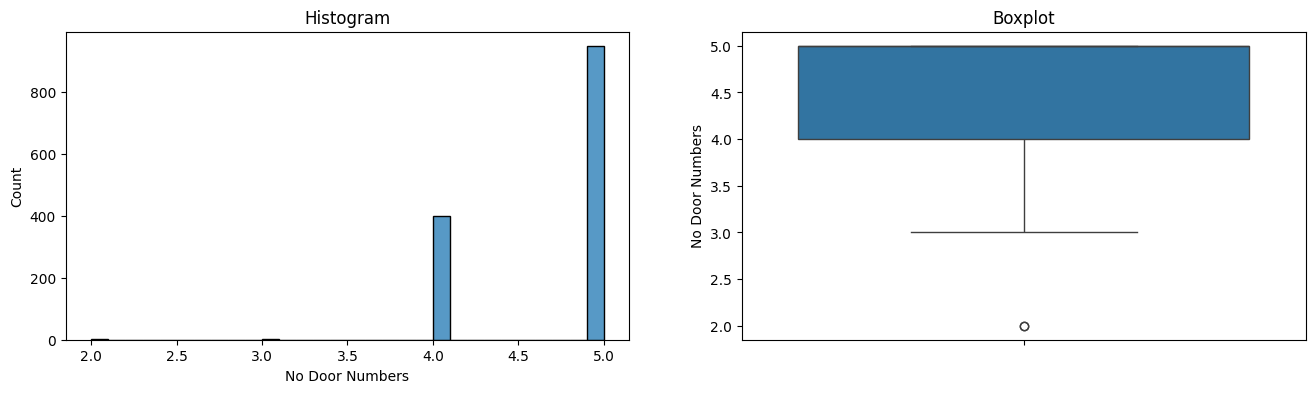

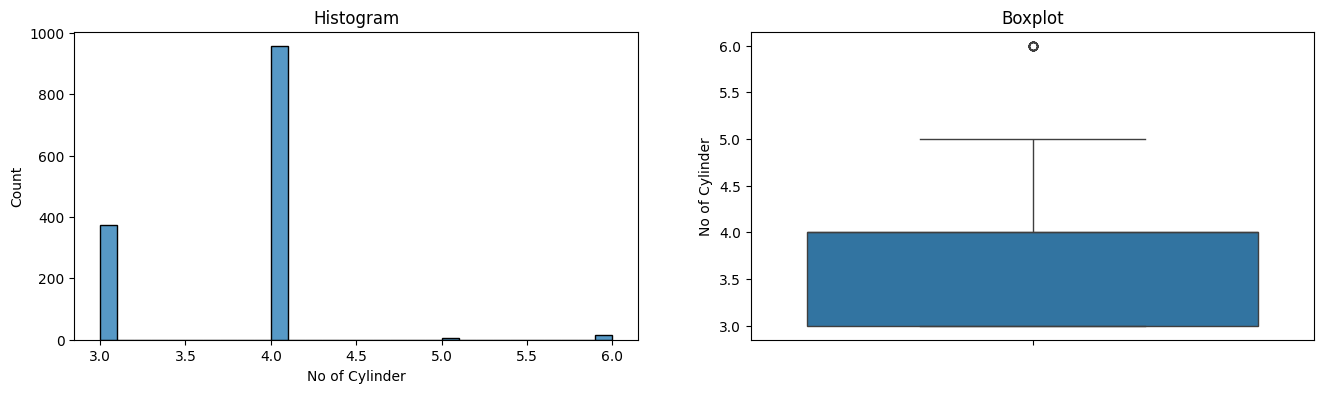

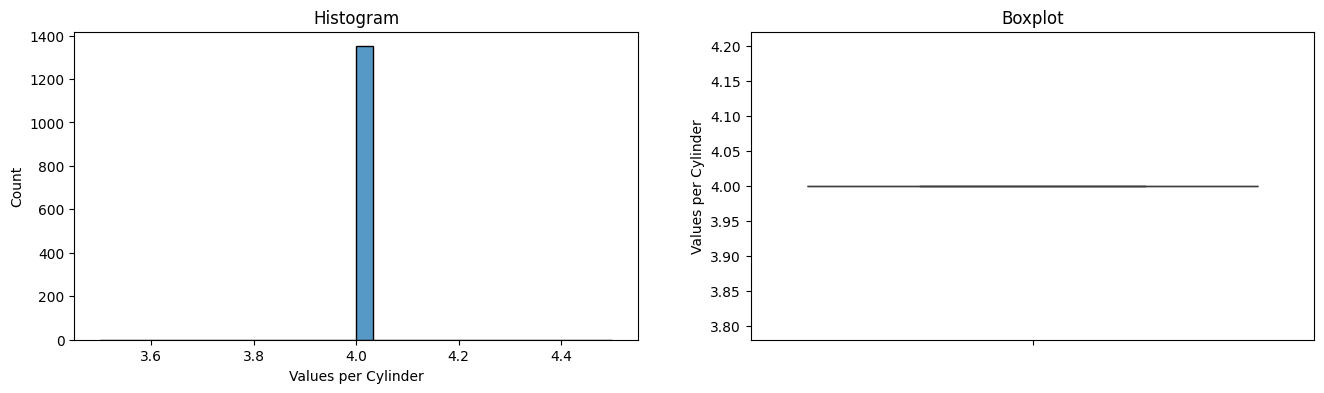

In [104]:
for m in nc:
    plots(df, m)

In [105]:
# for Q-Q plots
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer

def diagnostic_plots(df, variable):

    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable

    plt.figure(figsize=(15, 6))

    # histogram
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")

    # q-q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()



### Changing the distribution of the 'price_new' and 'kms' columns

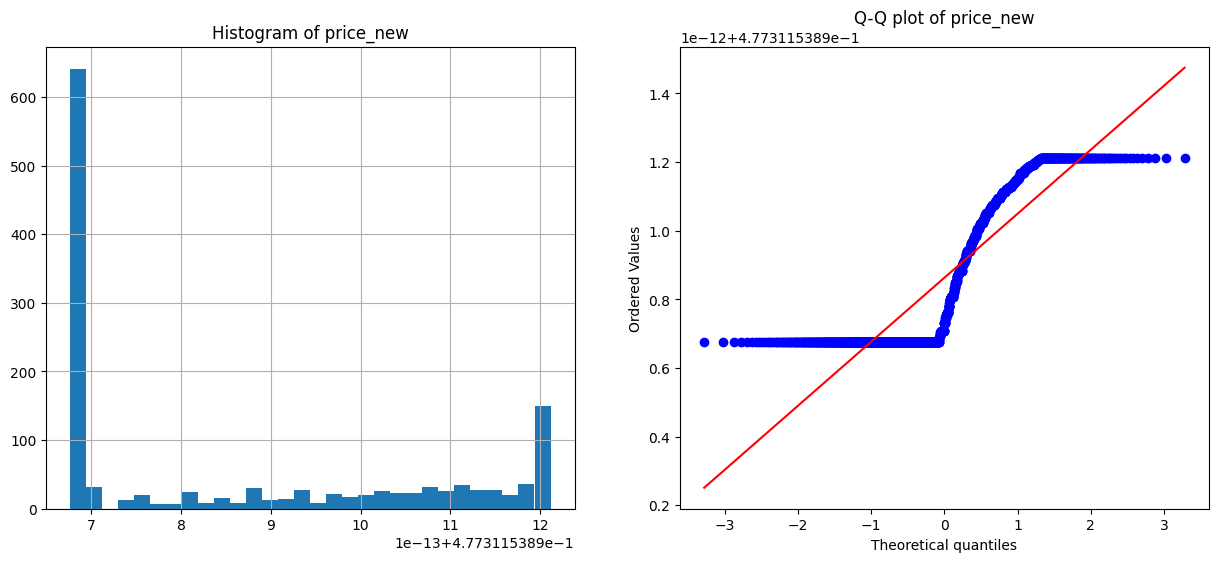

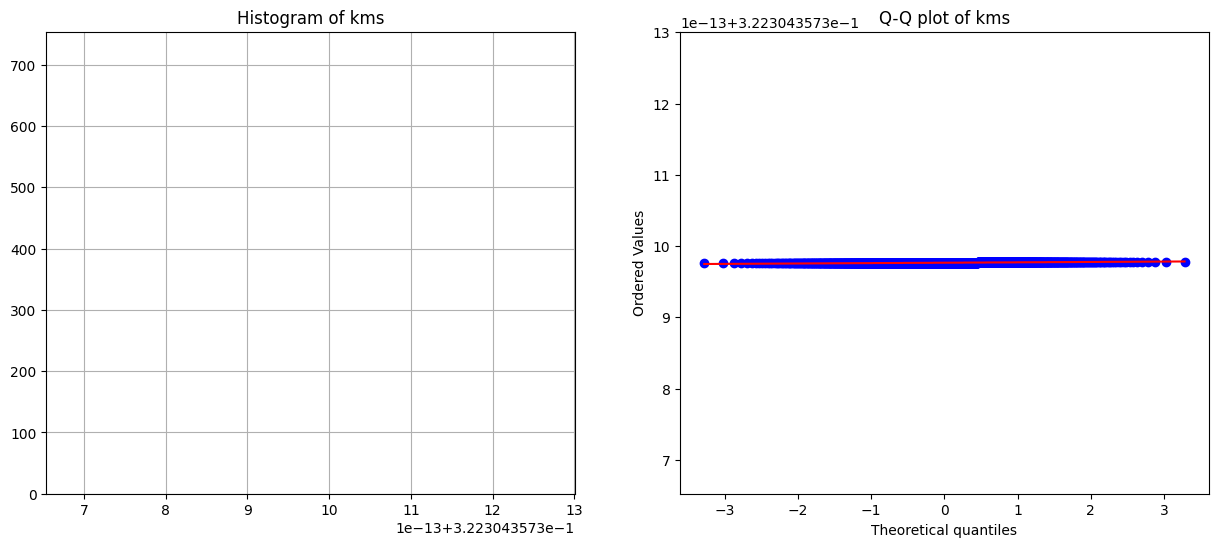

In [106]:
# with open-source packages
from sklearn.preprocessing import PowerTransformer

#transforming the ''price_new' column using "box-cox"
transformer1 = PowerTransformer(method="box-cox", standardize=False)
transformer1.fit(df[['price_new']])
# transformer1.set_output(transform="pandas")
df['price_new']= transformer1.transform(df[['price_new']])

diagnostic_plots(df, 'price_new')

#transforming the 'kms' column using "box-cox"
transformer2 = PowerTransformer(method="box-cox", standardize=False)
transformer2.fit(df[['kms']])
# transformer2.set_output(transform="pandas")
df['kms']= transformer2.transform(df[['kms']])

diagnostic_plots(df, 'kms')

In [107]:
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [108]:
s=new_all_selected_features.index('price_new')
s1=new_all_selected_features[s]

# Removing the 'price_new' column from 'new_all_selected_features' list
new_all_selected_features.pop(s)
new_all_selected_features

['owner',
 'oem',
 'body_type',
 'registration_year',
 'alloy_wheel_size',
 'turbo_charger',
 'front_brake_type',
 'gear_box',
 'Rear Brake Type',
 'seating_capacity',
 'kms',
 'engine_displacement',
 'mileage',
 'wheel_base',
 'height',
 'kerb_weight',
 'length',
 'max_power',
 'max_torque',
 'width',
 'No Door Numbers',
 'No of Cylinder',
 'Values per Cylinder']

In [109]:
y=df[s1]
X=df[new_all_selected_features]


X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    test_size=0.20,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1080, 23), (270, 23))

In [110]:
mean_enc = MeanEncoder(variables=cc) #cc- categorical columns

In [111]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['owner', 'oem', 'body_type', 'registration_year',
                       'alloy_wheel_size', 'turbo_charger', 'front_brake_type',
                       'gear_box', 'Rear Brake Type', 'seating_capacity'])

In [112]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) registration_year.
  warnings.warn(


,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
1142,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,...,2700.0,1475.0,1270.0,4620.0,87.0,205.0,1775.0,4.0,4.0,4.0
653,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,...,2435.0,1675.0,830.0,3655.0,82.0,113.0,1620.0,5.0,4.0,4.0
700,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,...,2865.0,1658.0,1825.0,4688.0,184.0,336.0,1902.0,5.0,4.0,4.0
328,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,...,2590.0,1630.0,1280.0,4270.0,121.0,151.0,1780.0,5.0,4.0,4.0
332,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,0.477312,...,2380.0,1590.0,825.0,3565.0,62.0,96.0,1525.0,5.0,3.0,4.0


In [113]:
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      1
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
dtype: int64

In [114]:
X_test['price_new']=y_test
X_test.dropna(inplace=True)
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
price_new              0
dtype: int64

In [115]:
y_test=X_test['price_new']
X_test=X_test[new_all_selected_features]
X_test.shape

(269, 23)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
# Let's train a linear model.

# Instantiate a linear model.
linreg = LinearRegression()

# Train the model.
linreg.fit(scaler.transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
# print('Train set')
pred_train = linreg.predict(scaler.transform(X_train))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('Linear Regression r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = linreg.predict(scaler.transform(X_test))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('Linear Regression r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Linear Regression rmse: 8.99340805162131e-14
Linear Regression r2-score: 0.8174622027735003
Test set
Linear Regression rmse: 9.474999420708807e-14
Linear Regression r2-score: 0.7998115469258793



In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [120]:
hr=HistGradientBoostingRegressor(learning_rate=0.05,max_leaf_nodes=300,max_depth=200,
                                               max_iter=1000,
                                               random_state=2023)
# Train the model.
hr.fit(scaler.fit_transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
print('Train set')
pred_train = hr.predict(scaler.transform(X_train))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train)),4))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = hr.predict(scaler.transform(X_test))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test)),4))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Train set
HistGradientBoostingRegressor rmse: 1.0048294726573095e-14
HistGradientBoostingRegressor r2-score: 0.9977212906332507
Test set
HistGradientBoostingRegressor rmse: 6.41951817710737e-14
HistGradientBoostingRegressor r2-score: 0.9081063492963241



### Inverse transforming the target column and comparing the 'actual' and 'predicted' values

In [121]:
u1=pd.concat([y_train,y_test],axis=0)
u2=pd.concat([pd.Series(pred_train),pd.Series(pred_test)],axis=0)

pred=transformer1.inverse_transform(pd.DataFrame(u2,columns=['price_new']))
y= transformer1.inverse_transform(u1.values.reshape(-1, 1))
x=pd.DataFrame({'rv':list(y),'pv':list(pred)})
x['residuals']=(x['rv']-x['pv'])
x['error']=(((x['rv']-x['pv']))/(x['rv']))

x['residuals_cor']=[i[0] for i in x['residuals']]
x['error_cor']=[i[0] for i in x['error']]
x.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,rv,pv,residuals,error,residuals_cor,error_cor
0,[899047.0077152849],[903187.5457830861],[-4140.538067801157],[-0.004605474499407272],-4140.538068,-0.004605
1,[558989.4600613612],[555027.2562811736],[3962.203780187643],[0.007088154720757535],3962.203780,0.007088
2,[1652122.1071873892],[1641966.1732222764],[10155.933965112781],[0.00614720541594984],10155.933965,0.006147
3,[1019920.8052039185],[1007183.7731667968],[12737.03203712171],[0.012488255923532341],12737.032037,0.012488
4,[486879.25953472697],[486836.7841276503],[42.4754070766503],[8.724012420911249e-05],42.475407,0.000087


In [122]:
x['residuals'].max(),x['residuals'].min()

(array([600811.80101437]), array([-1984371.12504966]))

In [123]:
round(list(x['error'].max())[0],2),round(list(x['error'].min())[0],2)

(0.44, -1.2)

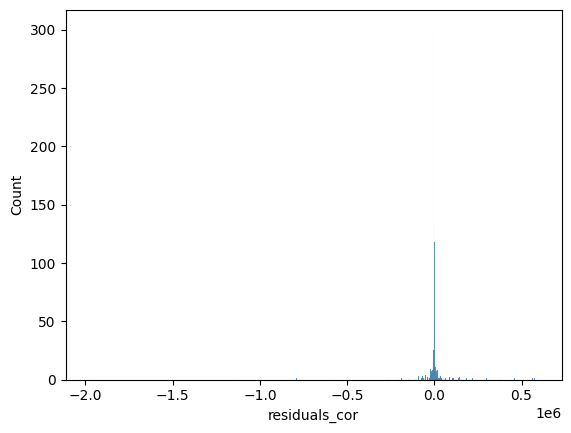

In [124]:
sns.histplot(x['residuals_cor'])
plt.show()

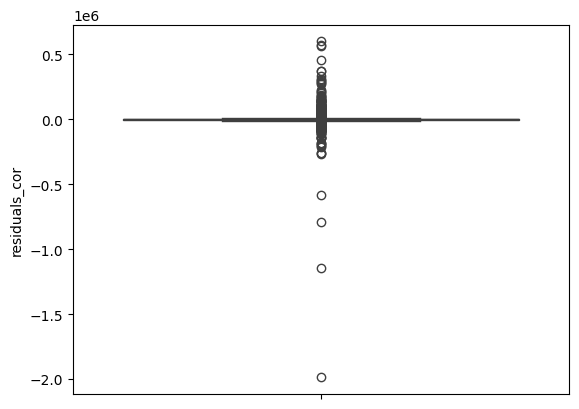

In [125]:
sns.boxplot(x['residuals_cor'])
plt.show()

In [126]:
x['residuals_cor'].describe()

count    1.349000e+03
mean     1.574246e+03
std      8.711261e+04
min     -1.984371e+06
25%     -2.487865e+03
50%      2.123914e+01
75%      2.469731e+03
max      6.008118e+05
Name: residuals_cor, dtype: float64

### From 248 features ,through various analysis and tests I used only 23 features to predict the 'price' of the cars.Hope the project results are good!!! 